In [29]:
from pathlib import Path
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import string
import scipy.constants

#own modules
from evaluation.utils import db, tools
from evaluation.processing import tools_ec
from evaluation.visualization import plot

# specific functions for study
general_funcs = tools.import_from_path('general_funcs', r'../general_funcs.py')

'done'

'done'

# S-number selection all samples

## Data

In [30]:
exp_ec, data_ec, exp_icpms, data_icpms, data_stability, \
        = db.get_exp_sfc_icpms(sql_ec='''SELECT *
                                         FROM exp_ec_expanded
                                         WHERE name_user = "n.roettcher"
                                             AND DATE(t_start__timestamp) IN ("2024-03-26","2024-04-03","2024-04-04")
                                             AND comment = 'act+SGEIS'
                                             AND name_setup_sfc_alias = "Sandwitch"
                                             #AND id_sample = 179 # equals loading__mg_Ir_cm2 > 1.6 but loading is added later
                                             #AND id_ML_technique IN (2, 3, 4) # activation techniques
                                             ;''',
                                add_data_stability_analysis=True,  
                               add_gravimetric=True
                              )
exp_ec.loc[exp_ec.fe_bottom_id_pump_out == 2, 'icpms_location'] = 'top'
exp_ec.loc[exp_ec.fe_bottom_id_pump_out == 3, 'icpms_location'] = 'bottom'

with db.connect().begin() as con:
    data_eis = exp_ec.dataset.get_data(con,'data_eis_analysis').rename(columns={'id_data_eis':'id_data_ec',
                                                                                'E_dc__VvsRE': 'E_WE_raw__VvsRE',
                                                                                 'I_dc__A': 'I__A'})
data_ec = pd.concat([data_ec, data_eis]).sort_index()



Link selected experiments to PublicationExport:  HTE09_hCCM_setup
 For table exp_sfc : inserted new experiments = 0 , skipped existing experiments = 152 
SELECT id_exp_sfc, t_start__timestamp,t_end__timestamp, id_exp_icpms, spots_spot_size__mm2, fc_top_name_flow_cell_A_opening_ideal__mm2, fc_top_name_flow_cell_A_opening_real__mm2, fc_top_id_sealing_A_opening__mm2, fc_top_id_PTL_A_PTL__mm2, fc_bottom_name_flow_cell_A_opening_ideal__mm2, fc_bottom_name_flow_cell_A_opening_real__mm2, fc_bottom_id_sealing_A_opening__mm2, fc_bottom_id_PTL_A_PTL__mm2  FROM match_exp_sfc_exp_icpms m   
           WHERE (id_exp_sfc)   IN (12858, 12859, 12860, 12861, 12862, 12863, 12864, 12865, 12866, 12867, 12868, 12869, 12870, 12871, 12872, 12873, 12874, 12875, 12876, 12938, 12939, 12940, 12941, 12942, 12943, 12944, 12945, 12946, 12947, 12948, 12949, 12950, 12951, 12952, 12953, 12954, 12955, 12956, 13035, 13036, 13037, 13038, 13039, 13040, 13041, 13042, 13043, 13044, 13045, 13046, 13047, 13048, 13049, 13050, 

/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/processing/tools_ec.py:964: UserWarning: Column: "j__mA_cm2geo_active_chosen" not available in data_ec. Will be skipped.
  warnings.warn(f'Column: "{col}" not available in data_ec. Will be skipped.')


Added snychronized timestamp column:  Timestamp_synchronized__s
Added snychronized timestamp column:  t_delaycorrected__timestamp_sfc_pc_synchronized__s
Read data from "data_stability_analysis" ...
SELECT * FROM data_stability_analysis WHERE (`id_exp_ec_dataset`) IN (249.0, 250.0, 251.0, 264.0, 265.0, 266.0, 267.0, 268.0, 269.0, 270.0, 271.0, 272.0);
Done in  0:00:00.063297
Read data from "data_eis_analysis" ...
SELECT * FROM data_eis_analysis WHERE (`id_exp_sfc`) IN (12858, 12859, 12860, 12861, 12862, 12863, 12864, 12865, 12866, 12867, 12868, 12869, 12870, 12871, 12872, 12873, 12874, 12875, 12876, 12938, 12939, 12940, 12941, 12942, 12943, 12944, 12945, 12946, 12947, 12948, 12949, 12950, 12951, 12952, 12953, 12954, 12955, 12956, 13035, 13036, 13037, 13038, 13039, 13040, 13041, 13042, 13043, 13044, 13045, 13046, 13047, 13048, 13049, 13050, 13051, 13052, 13053, 13149, 13150, 13151, 13152, 13153, 13154, 13155, 13156, 13157, 13158, 13159, 13160, 13161, 13162, 13163, 13164, 13165, 13166, 13

## Data analysis routine

In [31]:
time_shift__s=0
overlay_cols =  ['id_sample', 'id_spot', 'icpms_location']
cols_ec_to_icpms=['loading__mg_Ir_cm2', 'ec_name_technique']
icpms_x_col='t_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s'
icpms_y_col = 'dm_dt_S__ng_s_cm2geo_fc_bottom_PTL'
icpms_y_cols_background_correction = ['dm_dt__pg_s', icpms_y_col,] # icpms_y_col must be last
no_datapoints_Snumber_selection=60  



if type(cols_ec_to_icpms) != list:
    cols_ec_to_icpms = [cols_ec_to_icpms]

    

exp_ec_overlay, data_ec_overlay, exp_icpms_overlay, data_icpms_overlay  \
        = db.overlay_exp_sfc_icpms(exp_ec, data_ec, exp_icpms, data_icpms,
                                   overlay_cols=overlay_cols,
                                   cols_ec_to_icpms=cols_ec_to_icpms
                                  )

## correct time sync for length of first technique (different for different MLs)
first_exp_ec_technique = exp_ec_overlay.groupby(overlay_cols).first()
time_diff_first_exp_ec_technique= first_exp_ec_technique.t_end__timestamp - first_exp_ec_technique.t_start__timestamp
time_correct_exp_ec = time_diff_first_exp_ec_technique - time_diff_first_exp_ec_technique.min()
time_correct_exp_ec.name='Timestamp_correction__timediff'
data_ec_overlay.loc[:, 'Timestamp_synchronized_corrected__s'] = data_ec_overlay.Timestamp_synchronized__s - data_ec_overlay.join(time_correct_exp_ec, ).Timestamp_correction__timediff.dt.seconds
data_icpms_overlay.loc[:, 't_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s'] = data_icpms_overlay.t_delaycorrected__timestamp_sfc_pc_synchronized__s - data_icpms_overlay.join(time_correct_exp_ec, ).Timestamp_correction__timediff.dt.seconds
data_icpms_overlay.loc[:, 'dm_dt__pg_s'] = data_icpms_overlay.dm_dt__ng_s *1000

## add column is_during_ocp
data_icpms_overlay.loc[:, 'is_during_ocp'] = data_icpms_overlay.id_exp_sfc.isin(exp_ec.loc[exp_ec.ec_name_technique == 'exp_ec_ocp', :].index)


def avg_timeshift(exp_ec_overlay, data_ec_overlay, exp_icpms_overlay, data_icpms_overlay, time_shift__s=time_shift__s):
    # shifting top timestamp - assuming too late rise in counts due to diffusion broadening during delay time
    # shift time of top measurement
    # remove all data points below 0s (averaging and calculation of ratio will be performed on number of data points assuming time is synced so ignoring actual timestamp)
    data_icpms_overlay.loc[data_icpms_overlay.index.get_level_values(level='icpms_location') == 'top', 
                                    't_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s'] += time_shift__s
    data_icpms_overlay = data_icpms_overlay.loc[(data_icpms_overlay.t_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s > 0 ), :]

    return data_icpms_overlay

data_icpms_overlay = avg_timeshift(exp_ec_overlay, data_ec_overlay, exp_icpms_overlay, data_icpms_overlay, time_shift__s=time_shift__s)



######
# Baseline correction for Iridium 
####
for icpms_y_col_background_correction in icpms_y_cols_background_correction:
    
    data_icpms_overlay, icpms_y_col_background, icpms_y_col_background_corrected\
                = general_funcs.background_correction(
                      icpms_x_col=icpms_x_col,
                      icpms_y_col=icpms_y_col_background_correction,
                      data_icpms_overlay=data_icpms_overlay,
                      y_col_background='_background',
                      y_col_background_corrected='_background_corrected',
                      debug=False,
                      )
### baseline correction finished

icpms_y_col_background = icpms_y_col+'_background'
icpms_y_col_background_corrected =  icpms_y_col + '_background_corrected'

# data selection for S-number
gholdgeis_exp = exp_ec_overlay.loc[exp_ec_overlay.ec_name_technique.isin(['exp_ec_ghold', 'exp_ec_geis'])].index.get_level_values('id_exp_sfc')
exp_ec_overlay.loc[exp_ec_overlay.ghold_I_hold__A.notna(), 'I_step__A'] = exp_ec_overlay.loc[exp_ec_overlay.ghold_I_hold__A.notna(), 'ghold_I_hold__A']
exp_ec_overlay.loc[exp_ec_overlay.geis_I_dc__A.notna(), 'I_step__A'] = exp_ec_overlay.loc[exp_ec_overlay.geis_I_dc__A.notna(), 'geis_I_dc__A']
exp_ec_overlay.loc[exp_ec_overlay.index.get_level_values('id_exp_sfc').isin(
                                exp_ec_overlay.loc[((exp_ec_overlay.I_step__A.notna()) & (exp_ec_overlay.id_ML_technique > 3)), :]\
                                              .reset_index()\
                                              .groupby(exp_ec_overlay.index.names[:-1]+['ec_name_technique', 'I_step__A'])\
                                              .nth(0)\
                                              .id_exp_sfc), 
                   'scan_direction'] = 1
exp_ec_overlay.loc[exp_ec_overlay.index.get_level_values('id_exp_sfc').isin(
                                exp_ec_overlay.loc[((exp_ec_overlay.I_step__A.notna()) & (exp_ec_overlay.id_ML_technique > 3)), :]\
                                              .reset_index()\
                                              .groupby(exp_ec_overlay.index.names[:-1]+['ec_name_technique', 'I_step__A'])\
                                              .nth(1)\
                                              .id_exp_sfc), 
                   'scan_direction'] = 2
exp_ec_overlay.loc[exp_ec_overlay.id_ML_technique == 3, 'scan_direction'] = 0
exp_ec_overlay.loc[lambda row: ((row.I_step__A == row.I_step__A.max())
                                &(row.id_ML_technique > 3)), 'scan_direction'] = 1.5

index_selSnumber = data_icpms_overlay.index.names[:-1]+['scan_direction', 'I_step__A', ]

def select_data_Snumber(group):
    if ((group.index.get_level_values('scan_direction')== 2).all() 
            and (group.index.get_level_values('I_step__A')<= 0.002).all()):
        return group.tail(65+no_datapoints_Snumber_selection).head(no_datapoints_Snumber_selection) # 65 seconds before end of technique, due to bubble in one measurment
    else:
        return group.tail(no_datapoints_Snumber_selection)

data_icpms_overlay_Snumber_selection = data_icpms_overlay.loc[data_icpms_overlay.id_exp_sfc.isin(gholdgeis_exp)]\
                .join(exp_ec_overlay.reset_index().set_index('id_exp_sfc').loc[:, ['I_step__A', 'scan_direction']], on='id_exp_sfc')\
                .reset_index().set_index(index_selSnumber)\
                .groupby(index_selSnumber,as_index=False).apply(select_data_Snumber).reset_index().set_index(index_selSnumber).drop(columns=['level_0'])                
exp_icpms_overlay_Snumber_selection = data_icpms_overlay_Snumber_selection.groupby(index_selSnumber).mean()
exp_icpms_overlay_Snumber_selection = exp_icpms_overlay_Snumber_selection.loc[exp_icpms_overlay_Snumber_selection.index.get_level_values('name_isotope_analyte')=='Ir193', :]


# Detection limit for fig:polcurve_stability
data_icpms_overlay_DetLimit_selection = data_icpms_overlay.loc[(
                        (data_icpms_overlay.index.get_level_values('name_isotope_analyte')=='Ir193')
                       )]\
                .groupby(exp_icpms_overlay.index.names).tail(n=100)
dm_dt_S_std_allexp__g_s_cm2 = data_icpms_overlay_DetLimit_selection.groupby(exp_icpms_overlay.index.names).dm_dt_S__ng_s_cm2geo_fc_bottom_PTL.std()*1e-9




SELECT id_exp_sfc, t_start__timestamp,t_end__timestamp, id_exp_icpms, spots_spot_size__mm2  FROM match_exp_sfc_exp_icpms m   
           WHERE (id_exp_sfc)   IN (12858, 12859, 12860, 12861, 12862, 12863, 12864, 12865, 12866, 12867, 12868, 12869, 12870, 12871, 12872, 12873, 12874, 12875, 12876, 12938, 12939, 12940, 12941, 12942, 12943, 12944, 12945, 12946, 12947, 12948, 12949, 12950, 12951, 12952, 12953, 12954, 12955, 12956, 13035, 13036, 13037, 13038, 13039, 13040, 13041, 13042, 13043, 13044, 13045, 13046, 13047, 13048, 13049, 13050, 13051, 13052, 13053, 13149, 13150, 13151, 13152, 13153, 13154, 13155, 13156, 13157, 13158, 13159, 13160, 13161, 13162, 13163, 13164, 13165, 13166, 13167, 13208, 13209, 13210, 13211, 13212, 13213, 13214, 13215, 13216, 13217, 13218, 13219, 13220, 13221, 13222, 13223, 13224, 13225, 13226, 13281, 13282, 13283, 13284, 13285, 13286, 13287, 13288, 13289, 13290, 13291, 13292, 13293, 13294, 13295, 13296, 13297, 13298, 13299, 13352, 13353, 13354, 13355, 13356, 13357

## Detection limit in different units

In [32]:
display(data_icpms_overlay_DetLimit_selection.groupby(exp_icpms_overlay.index.names).c_a__mug_L.std()*3*1e-6) ## c_ir in g/L
display(data_icpms_overlay_DetLimit_selection.groupby(exp_icpms_overlay.index.names).c_a__mug_L.std()*3*1e-6/192.22) ## c_ir in mol/L
data_icpms_overlay_DetLimit_selection.groupby(exp_icpms_overlay.index.names).dm_dt_S__ng_s_cm2geo_fc_bottom_PTL.std()*3*1e-9 ## dm/(dt*S) in g / s / cm2

id_sample  id_spot  icpms_location  id_exp_icpms  name_isotope_analyte  name_isotope_internalstandard
179        5        bottom          737           Ir193                 Re187                            8.296568e-10
           7        top             709           Ir193                 Re187                            1.675544e-09
           8        top             709           Ir193                 Re187                            1.454350e-09
           10       bottom          737           Ir193                 Re187                            6.555832e-10
180        3        top             709           Ir193                 Re187                            1.663127e-09
           4        top             724           Ir193                 Re187                            1.424228e-09
181        3        top             724           Ir193                 Re187                            2.327334e-09
           4        top             724           Ir193                 

id_sample  id_spot  icpms_location  id_exp_icpms  name_isotope_analyte  name_isotope_internalstandard
179        5        bottom          737           Ir193                 Re187                            4.316183e-12
           7        top             709           Ir193                 Re187                            8.716802e-12
           8        top             709           Ir193                 Re187                            7.566068e-12
           10       bottom          737           Ir193                 Re187                            3.410588e-12
180        3        top             709           Ir193                 Re187                            8.652207e-12
           4        top             724           Ir193                 Re187                            7.409367e-12
181        3        top             724           Ir193                 Re187                            1.210766e-11
           4        top             724           Ir193                 

id_sample  id_spot  icpms_location  id_exp_icpms  name_isotope_analyte  name_isotope_internalstandard
179        5        bottom          737           Ir193                 Re187                            1.857317e-13
           7        top             709           Ir193                 Re187                            3.879224e-13
           8        top             709           Ir193                 Re187                            3.367115e-13
           10       bottom          737           Ir193                 Re187                            1.467626e-13
180        3        top             709           Ir193                 Re187                            3.850477e-13
           4        top             724           Ir193                 Re187                            3.207788e-13
181        3        top             724           Ir193                 Re187                            5.241852e-13
           4        top             724           Ir193                 

## sfig:dis_pro_select_data_Snumber Display selected data for S-number

/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/visualization/plot.py:3230: UserWarning: weakly reference error, all PlotDataStorage objects are deleted.
  warnings.warn(


 File  sfig_dis_pro_select_data_Snumber.pdf  already exists 


Overwrite?
	0: False
	1: True
Your choice:  1


 Plot  sfig_dis_pro_select_data_Snumber.pdf  successfully saved 
![[Binder_export/Figures/Fig_6_S1_S8_S9_10_S11_S12/sfig_dis_pro_select_data_Snumber.pdf]] <br> *jupyter notebook source:* ![[Binder_export/Figures/Fig_6_S1_S8_S9_10_S11_S12/$$dummy_replaced_by_obsidian_jupyter$$]]


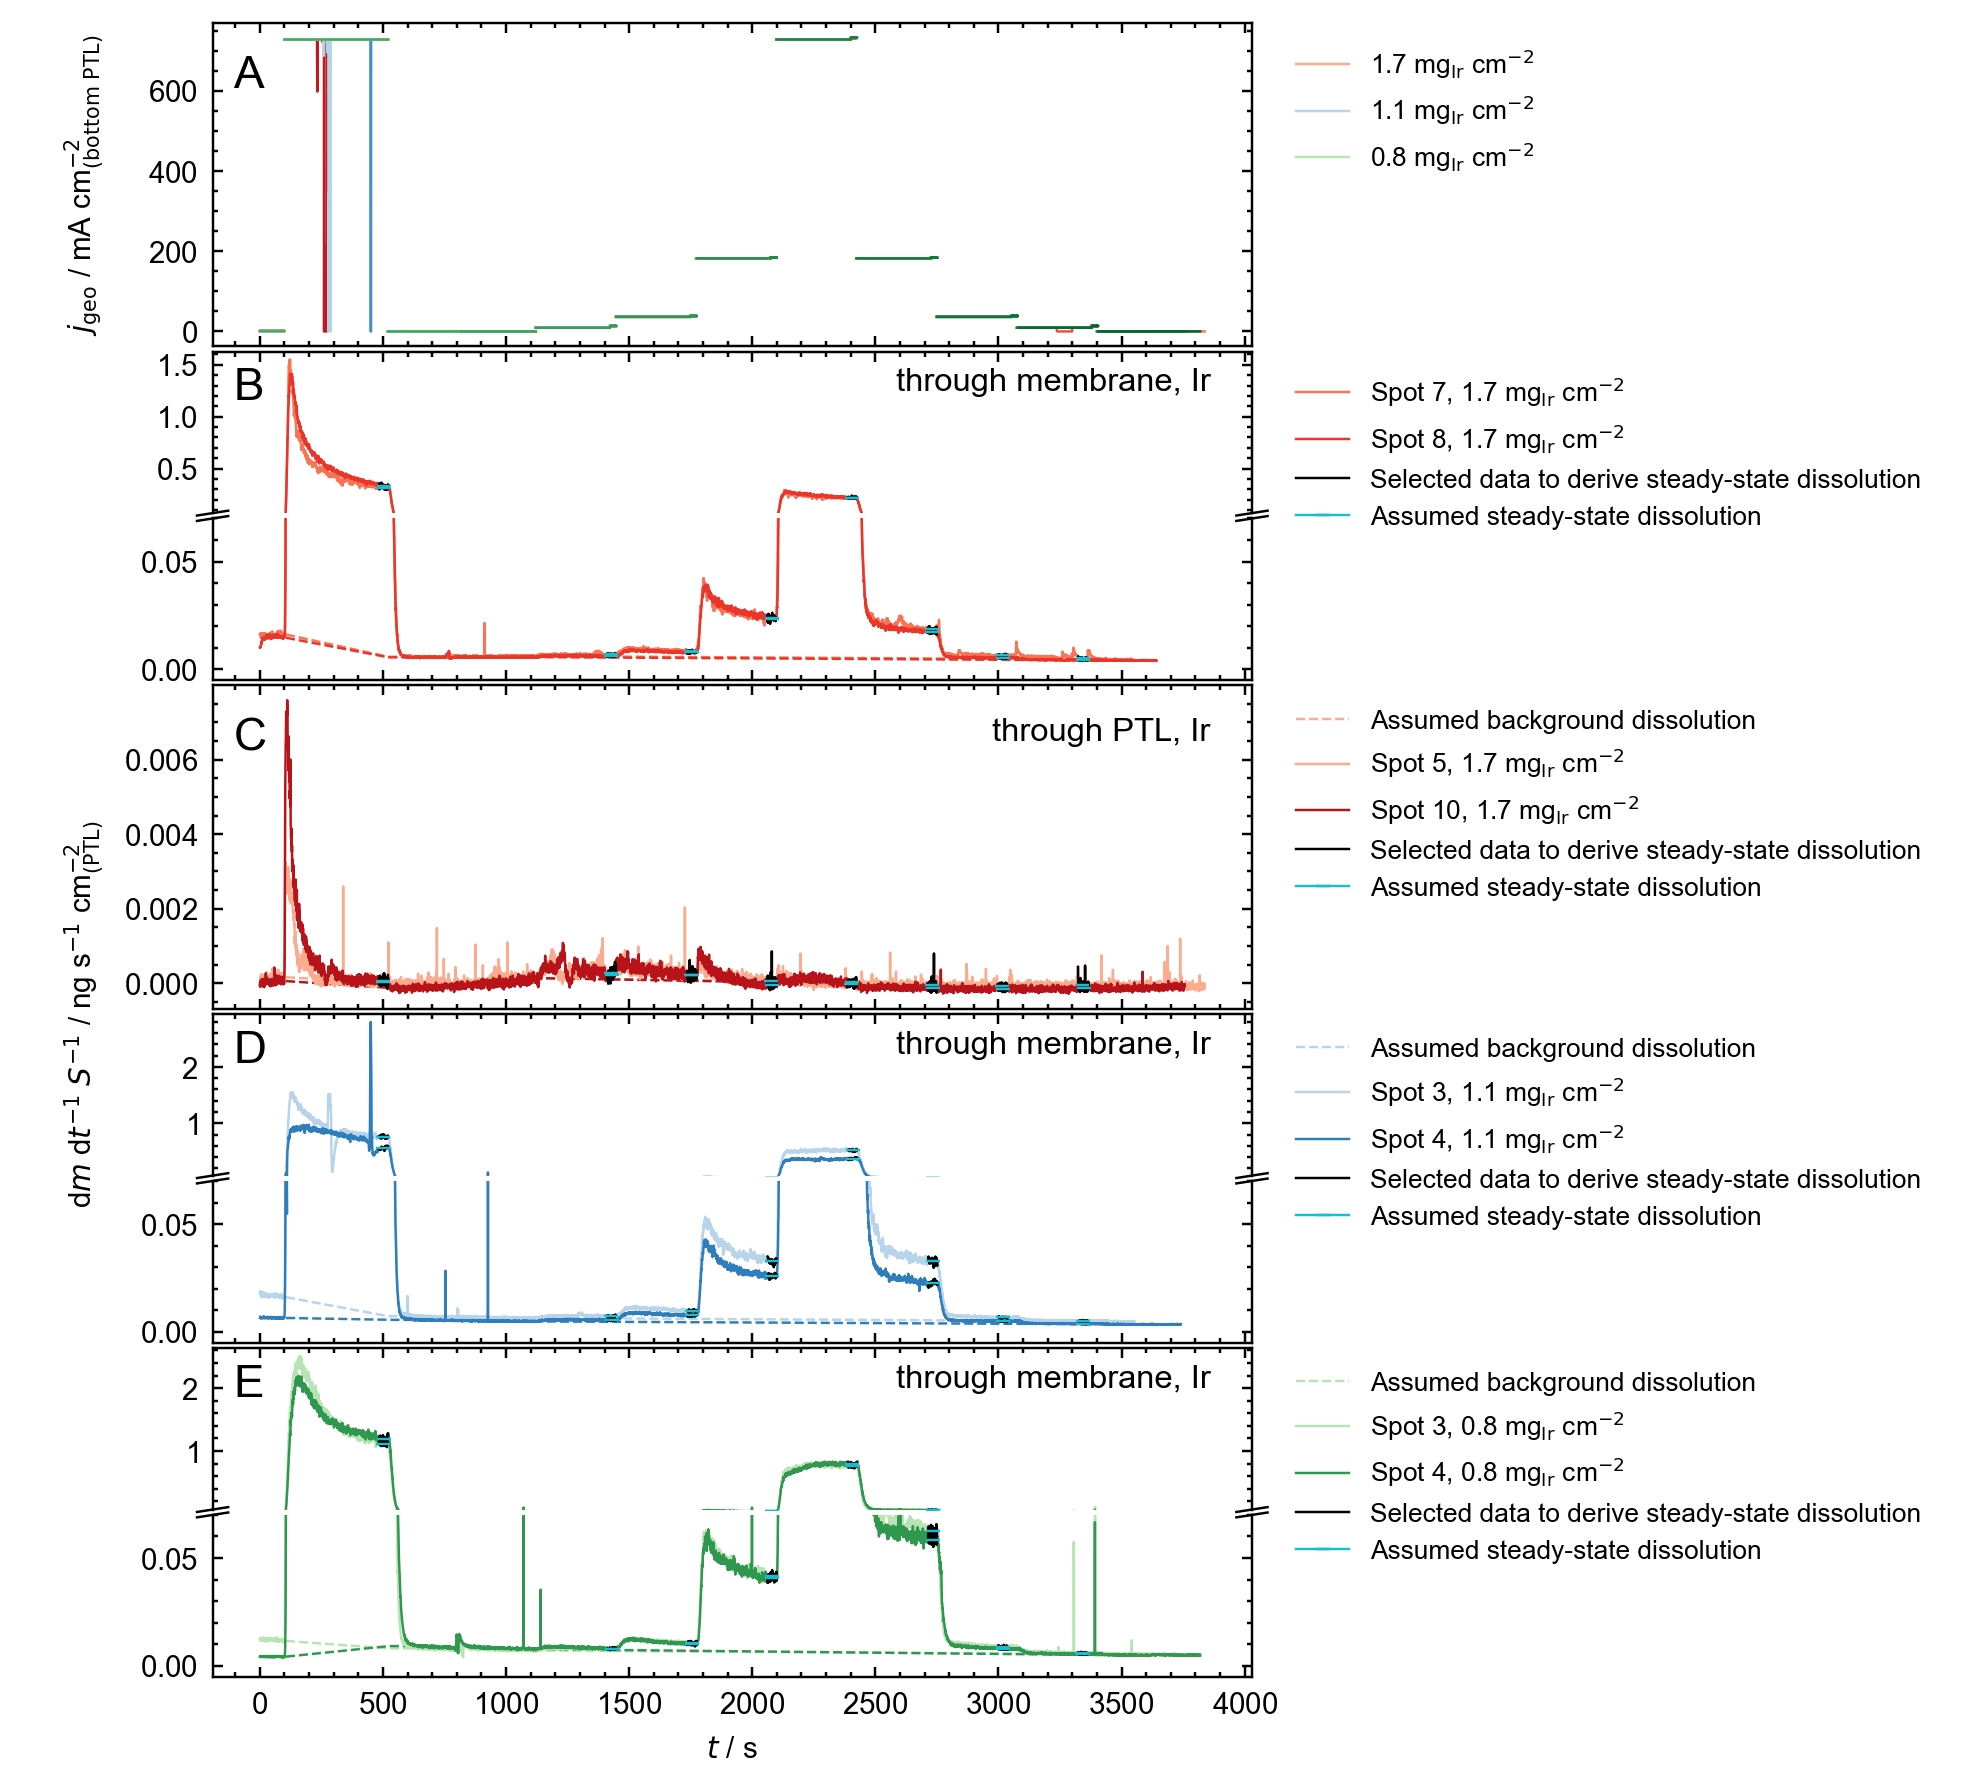

In [33]:
exp_icpms_overlay_Snumber_selection = data_icpms_overlay_Snumber_selection.groupby(index_selSnumber).mean()
exp_icpms_overlay_Snumber_selection = exp_icpms_overlay_Snumber_selection.loc[exp_icpms_overlay_Snumber_selection.index.get_level_values('name_isotope_analyte')=='Ir193', :]

plot_name='sfig_dis_pro_select_data_Snumber'

plot.manual_col_to_axis_label['t_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s'] = '$t$ / s' 
x_col_ICPMS='t_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s'

with plt.rc_context(plot.get_style(style='doubleColumn',
                                  increase_fig_height=3,
                                   add_margins= {'left': 0.8,'right': 6,},
                                   add_margins_between_subplots={'hspace':0.2},
                                  interactive =True,)):
    plot_storage = plot.PlotDataStorage(plot_name, overwrite_existing=True)
    

    fig = plt.figure()
    
    samples = exp_icpms_overlay.index.get_level_values('id_sample').unique().tolist()
    
    height_ratios=[1,]
    height_ratios_top=[.5,.5,]
    height_ratios_bottom=[1.,]
    for id_sample in samples:
        if 'top' in exp_icpms_overlay.loc[lambda row: row.index.get_level_values('id_sample') == id_sample].index.get_level_values('icpms_location').unique():
            height_ratios += height_ratios_top
        if 'bottom' in exp_icpms_overlay.loc[lambda row: row.index.get_level_values('id_sample') == id_sample].index.get_level_values('icpms_location').unique():
            height_ratios += height_ratios_bottom    

    gs = gridspec.GridSpec(len(height_ratios), 
                           1, 
                           height_ratios=height_ratios)
    ax1 = fig.add_subplot(gs[0, 0])
    axs = [ax1,]
    axs_broken = []
    gs_idx = 1
    for id_sample, color in zip(samples, 
                                ['Reds', 'Blues', 'Greens']):
        ax_top_upper = None
        ax_top_lower = None
        ax_bottom = None
        
        if 'top' in exp_icpms_overlay.loc[lambda row: row.index.get_level_values('id_sample') == id_sample].index.get_level_values('icpms_location').unique():
            ax_top_upper = fig.add_subplot(gs[gs_idx, 0], sharex=ax1)
            gs_idx += 1
        
            ax_top_lower = fig.add_subplot(gs[gs_idx, 0], sharex=ax1)
            gs_idx += 1
            
            plot.combine_broken_axes(ax_top_left=ax_top_upper,
                ax_bottom_right=ax_top_lower,
                broken_ratio= height_ratios_top[1]/height_ratios_top[0],
                broken_axis='y',
               )
            axs += [ax_top_upper, ]
            
            axs_broken += [[ax_top_upper, ax_top_lower], ]

        if 'bottom' in exp_icpms_overlay.loc[lambda row: row.index.get_level_values('id_sample') == id_sample].index.get_level_values('icpms_location').unique():
            ax_bottom = fig.add_subplot(gs[gs_idx, 0], sharex=ax1)
            ax_bottom.tick_params(axis='x', which='both', labelbottom=False)
            gs_idx += 1
            axs += [ax_bottom, ]



        
        exp_icpms_overlay.dataset.add_column('ax_col', 
                                     rowindexers=[((exp_icpms_overlay.index.get_level_values('name_isotope_analyte') == 'Ir193') 
                                                   & (exp_icpms_overlay.index.get_level_values('icpms_location') == 'top')
                                                   & (exp_icpms_overlay.index.get_level_values('id_sample')==id_sample)
                                                  ),
                                                  ((exp_icpms_overlay.index.get_level_values('name_isotope_analyte') == 'Ti47')
                                                   & (exp_icpms_overlay.index.get_level_values('icpms_location') == 'top')
                                                   & (exp_icpms_overlay.index.get_level_values('id_sample')==id_sample)
                                                  ),
                                                  ((exp_icpms_overlay.index.get_level_values('name_isotope_analyte') == 'Ir193') 
                                                   & (exp_icpms_overlay.index.get_level_values('icpms_location') == 'bottom')
                                                   & (exp_icpms_overlay.index.get_level_values('id_sample')==id_sample)
                                                  ),
                                                  ((exp_icpms_overlay.index.get_level_values('name_isotope_analyte') == 'Ti47')
                                                   & (exp_icpms_overlay.index.get_level_values('icpms_location') == 'bottom')
                                                   & (exp_icpms_overlay.index.get_level_values('id_sample')==id_sample)
                                                  ),
                                                 ],
                                     values=[ax_top_upper, 
                                             None, 
                                             ax_bottom,
                                             None,
                                            ])\
                                .add_column('ax_col_inset',
                                     rowindexers=[((exp_icpms_overlay.index.get_level_values('name_isotope_analyte') == 'Ir193') 
                                                   & (exp_icpms_overlay.index.get_level_values('icpms_location') == 'top')
                                                   & (exp_icpms_overlay.index.get_level_values('id_sample')==id_sample)
                                                  ),
                                                 ],
                                     values=[ax_top_lower, 
                                            ])\
                            .add_column('color', 
                                         rowindexers=[(exp_icpms_overlay.index.get_level_values('id_sample')==id_sample)],
                                         values=[color],
                                         cmap_min=0.3,cmap_max=0.9,
                                      )\
                            .return_dataset()
        exp_ec_overlay.dataset.add_column('color', 
                                         rowindexers=[(exp_ec_overlay.index.get_level_values('id_sample')==id_sample)],
                                         values=[color],
                                         cmap_min=0.3,cmap_max=0.9,
                                      )\
                            .return_dataset()    
        
    #Hide xaxis label on ax
    plt.setp(ax1.get_xticklabels(), visible=False)


    ax_all = plot.add_empty_subplot(fig, gs[1:, 0])
    if icpms_y_col == 'dm_dt_S__ng_s_cm2geo_fc_bottom_PTL':
            ax_all.set_ylabel('d$m$ d$t^{-1}$ $S^{-1}$ / ng s$^{-1}$ cm$^{-2}_{\mathrm{(PTL)}}$')
 
    exp_ec_overlay = exp_ec_overlay\
                    .dataset\
                    .add_column('label', 
                                 values=exp_ec_overlay.loading__mg_Ir_cm2.apply(lambda x: '{0:.1f}'.format(x)).astype(str)+' mg$_{\mathrm{Ir}}$ cm$^{-2}$',
                                rowindexer_first_of_group=['id_sample', ],
                                )\
                    .plot(x_col='Timestamp_synchronized_corrected__s',
                         y_col='j__mA_cm2geo_fc_bottom_PTL',
                          ax=ax1,
                         data=data_ec_overlay,   
                    ) \
     .return_dataset()

    
    exp_icpms_overlay = exp_icpms_overlay\
                    .dataset\
                    .add_column('label', 
                                values= 'Assumed background dissolution',
                                rowindexer_first_of_group=['id_sample'],
                                 )\
                    .plot(x_col=x_col_ICPMS,
                                             y_col=icpms_y_col_background,
                                              ax='ax_col',
                                             data=data_icpms_overlay,   
                                                   linestyle='--',
                          axlabel_auto=False,
                                        )\
                    .add_column('label', values= 'Spot '+exp_icpms_overlay.index.get_level_values('id_spot').astype(str) + ', '+ exp_icpms_overlay.loading__mg_Ir_cm2.apply(lambda x: '{0:.1f}'.format(x))+' mg$_{\mathrm{Ir}}$ cm$^{-2}$',
                                 )\
                    .plot(x_col=x_col_ICPMS,
                         y_col=icpms_y_col,
                          ax='ax_col',
                         data=data_icpms_overlay,   
                          axlabel_auto=False,
                    )\
                    .plot(x_col=x_col_ICPMS,
                                             y_col=icpms_y_col_background,
                                              ax='ax_col_inset',
                                             data=data_icpms_overlay,   
                                            linestyle='--',
                          axlabel_auto=False,
                                        )\
                    .plot(x_col=x_col_ICPMS,
                         y_col=icpms_y_col,
                          ax='ax_col_inset',
                         data=data_icpms_overlay,  
                          axlabel_auto=False,
                    )\
                    .return_dataset()


    exp_icpms_overlay_Snumber_selection = exp_icpms_overlay_Snumber_selection.join(exp_icpms_overlay.loc[:, ['ax_col', 'ax_col_inset', 'color']])
    exp_icpms_overlay_Snumber_selection = exp_icpms_overlay_Snumber_selection\
                    .dataset\
                    .add_column('label', values= 'Selected data to derive steady-state dissolution',
                                            rowindexer_first_of_group=['id_sample', 'icpms_location']
                                         )\
                    .plot(x_col=x_col_ICPMS,
                         y_col=icpms_y_col,
                          ax='ax_col',
                         data=data_icpms_overlay_Snumber_selection, 
                          color='black',
                          axlabel_auto=False,
                    )\
                    .plot(x_col=x_col_ICPMS,
                         y_col=icpms_y_col,
                          ax='ax_col_inset',
                         data=data_icpms_overlay_Snumber_selection, 
                          color='black',
                              axlabel_auto=False,
                    )\
                    .add_column('label', values= 'Assumed steady-state dissolution',
                                            rowindexer_first_of_group=['id_sample', 'icpms_location']
                                         )\
                    .plot(x_col=x_col_ICPMS,
                         y_col=icpms_y_col,
                          ax='ax_col',
                          color='tab:cyan',
                         marker='_',
                          axlabel_auto=False,
                    )\
                    .plot(x_col=x_col_ICPMS,
                         y_col=icpms_y_col,
                          ax='ax_col_inset', 
                          color='tab:cyan',
                         marker='_',
                         # markersize=1,
                         # linestyle='',
                          axlabel_auto=False,
                    )\
                    .return_dataset()
    


    icpms_text = {'top': 'through membrane',
                 'bottom': 'through PTL',}

    for index, row in exp_icpms_overlay.reset_index().loc[:, ['ax_col', 'icpms_location', 'analyte_element']].drop_duplicates().dropna().iterrows():
        row.ax_col.text(0.96, 0.9, 
                        icpms_text[row.icpms_location] + ', ' + row.analyte_element,  
                        transform=row.ax_col.transAxes, 
                        ha='right', # this doesn't work properly for interactive plot rendering
                        va='top')

    # Plot labels
    plot_labels = list(string.ascii_uppercase)[:len(axs)]

    for ax, plot_label in zip(axs, plot_labels):
        ax.text(0.02, 0.9, plot_label, 
                    horizontalalignment='left', 
                    verticalalignment='top', 
                    transform=ax.transAxes,
                    fontsize=11)

    

    for i, (ax_upper, ax_lower) in enumerate(axs_broken):
        #print(ax_upper, ax_lower)            
        ax_upper.set_ylim([.07, ax_upper.get_ylim()[1]])
        ax_lower.set_ylim([-.005, .07])
        if i != len(axs_broken)-1:
            ax_lower.set_xlabel('')
            ax_lower.tick_params(axis='x', which='both', labelbottom=False)
        else:
            ax_lower.set_xlabel(plot.get_axis_label(x_col_ICPMS))
 


        
    for ax in axs:    
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    



    fig.align_ylabels(axs+ [ax_all, ])
    plot_storage.export(fig, plot_format='pdf')
    
    

 

    
    
    plt.show()






## Derive S-number

In [34]:
data_icpms_overlay_Snumber_selection = data_icpms_overlay_Snumber_selection.loc[data_icpms_overlay_Snumber_selection.index.get_level_values('scan_direction').isin([1,1.5, 2]), :]

data_stability_top_bottom = pd.concat([
    data_icpms_overlay_Snumber_selection.groupby(index_selSnumber)[['dm_dt__pg_s', 'dm_dt__pg_s_background_corrected']].mean(),
    data_icpms_overlay_Snumber_selection.groupby(index_selSnumber)['t_delaycorrected__timestamp_sfc_pc'].first().rename('t_delaycorrected__timestamp_sfc_pc_first') ,
    data_icpms_overlay_Snumber_selection.groupby(index_selSnumber)['t_delaycorrected__timestamp_sfc_pc'].last().rename('t_delaycorrected__timestamp_sfc_pc_last') ,
], axis=1)


data_stability_top_bottom_Ir = data_stability_top_bottom.loc[data_stability_top_bottom.index.get_level_values('name_isotope_analyte')=='Ir193']

if (data_stability_top_bottom_Ir.dm_dt__pg_s_background_corrected <0).any():
    print('Some background corrected mass fluxes are negative! Set to 0. for:' )
    display(data_stability_top_bottom_Ir.loc[lambda row: row.dm_dt__pg_s_background_corrected <0], )
    data_stability_top_bottom_Ir.loc[lambda row: row.dm_dt__pg_s_background_corrected <0, 'dm_dt__pg_s_background_corrected'] = 0
    print('Done...')


def match_icpms_ec_stability(row):
    data_ec_overlay_selected = data_ec_overlay.loc[((data_ec_overlay.Timestamp > row.t_delaycorrected__timestamp_sfc_pc_first) 
                                                                       & (data_ec_overlay.Timestamp < row.t_delaycorrected__timestamp_sfc_pc_last)), 
                                                                      :]\
                                              .reset_index()
    
    return pd.Series([data_ec_overlay_selected.I__A.mean(), 
                      data_ec_overlay_selected.j__mA_mg_Ir_geo_fc_bottom_PTL.mean(), 
                      data_ec_overlay_selected.j__mA_cm2geo_fc_bottom_PTL.mean(), 
                      data_ec_overlay_selected.id_exp_sfc.iloc[0],
                      data_ec_overlay_selected.id_exp_sfc.iloc[-1],
                      ], 
                     index=['I__A', 
                            'j__mA_mg_Ir_geo_fc_bottom_PTL',
                            'j__mA_cm2geo_fc_bottom_PTL',
                            'id_exp_sfc_first',
                            'id_exp_sfc_last',
                           ])


# join with manually integrated data
data_stability.loc[lambda row: (row.name_analysis != 'all') , 'scan_direction'] = 1
data_stability.loc[lambda row: ((row.name_analysis != 'all') 
                                & (row.name_analysis.str.split('_', expand=True)[1] == 'back')), 'scan_direction'] = 2
data_stability.loc[lambda row: (row.name_analysis != 'all'), 'I_step__A'] =  data_stability.loc[lambda row: (row.name_analysis != 'all')].name_analysis.str.split('_', expand=True)[0].str.strip('mA').astype(float)/1000
data_stability.loc[lambda row: ((row.name_analysis != 'all')
                                &(row.I_step__A == row.I_step__A.max())
                                ), 'scan_direction'] = 1.5

data_stability.loc[lambda row: row.fe_bottom_id_pump_out == 2, 'icpms_location'] = 'top'
data_stability.loc[lambda row: row.fe_bottom_id_pump_out == 3, 'icpms_location'] = 'bottom'


data_stability_integrated_selected = data_stability.set_index(data_stability_top_bottom.index.names)\
                                                    .loc[lambda row: ((row.index.get_level_values('scan_direction').isin([1, 1.5, 2])) 
                                                                      &(row.index.get_level_values('name_isotope_analyte')=='Ir193'))]\
                                                    .sort_index()
  


data_stability_top_bottom_Ir = pd.concat([
                                                    data_stability_top_bottom_Ir,
                                                    data_stability_top_bottom_Ir.apply(match_icpms_ec_stability,
                                                                                              axis=1),
                                                    data_stability_integrated_selected.loc[:, ['n_product_of_interest_trapz__mol', 'n_dissolved_trapz__mol']],
                                                ], axis=1)



# charge differnce between top and bottom negligible - take only top 
data_stability_top_bottom_Ir.loc[data_stability_top_bottom_Ir.index.get_level_values('icpms_location')=='bottom'].I__A.to_numpy() \
#/ 
data_stability_top_bottom_Ir.loc[data_stability_top_bottom_Ir.index.get_level_values('icpms_location')=='top'].I__A.to_numpy()


def select_location_id_spot_diff(df, location):
    return_df_index = list(df.index.names)
    return_df_index.remove('icpms_location')
    return_df_index.remove('id_exp_icpms')
    return_df_index = list(map(lambda x: x.replace('id_spot', 'id_spot_diff'), return_df_index)) # replace id_spot with id_spot_diff

    return_df = df.loc[df.index.get_level_values('icpms_location')==location]
    return return_df\
             .join( return_df.reset_index().groupby(['id_sample']).apply(lambda group: pd.DataFrame([[id_spot_diff, id_spot] for id_spot_diff, id_spot in enumerate(group.id_spot.unique())], 
                                                                             columns=['id_spot_diff', 'id_spot'],
                                                                            ).set_index('id_spot')
                                                 )
                  )\
            .reset_index().set_index(return_df_index) 
data_stability_top_Ir = select_location_id_spot_diff(data_stability_top_bottom_Ir, 'top')
data_stability_bottom_Ir = select_location_id_spot_diff(data_stability_top_bottom_Ir, 'bottom')


Faraday__C_mol = scipy.constants.physical_constants['Faraday constant'][0]
n_electrons = 4
faradaic_efficiency = 1
M_Ir__g_mol = 192.22

data_stability_Ir = pd.concat([
    data_stability_top_Ir.loc[:, ['id_spot', 'I__A', 'j__mA_cm2geo_fc_bottom_PTL', 'j__mA_mg_Ir_geo_fc_bottom_PTL', 'n_product_of_interest_trapz__mol', 'n_dissolved_trapz__mol']],
    data_stability_top_Ir.dm_dt__pg_s_background_corrected.rename('dm_dt__pg_s_background_corrected_top'),
    data_stability_bottom_Ir.dm_dt__pg_s_background_corrected.rename('dm_dt__pg_s_background_corrected_bottom'),
    (data_stability_top_Ir.I__A / (n_electrons*Faraday__C_mol) * faradaic_efficiency).rename('dnO2_dt__mol_s'),
    (data_stability_top_Ir.dm_dt__pg_s * 1e-12 / M_Ir__g_mol).rename('dnIr_dt_top_nobaseline__mol_s'),
    (data_stability_top_Ir.dm_dt__pg_s_background_corrected * 1e-12 / M_Ir__g_mol).rename('dnIr_dt_top__mol_s'),
    (data_stability_bottom_Ir.dm_dt__pg_s_background_corrected * 1e-12 / M_Ir__g_mol).rename('dnIr_dt_bottom__mol_s'),
    ((data_stability_top_Ir.dm_dt__pg_s_background_corrected + data_stability_bottom_Ir.dm_dt__pg_s_background_corrected) * 1e-12 / M_Ir__g_mol).rename('dnIr_dt_sum__mol_s'),
    ((data_stability_bottom_Ir.dm_dt__pg_s_background_corrected / (data_stability_top_Ir.dm_dt__pg_s_background_corrected+data_stability_bottom_Ir.dm_dt__pg_s_background_corrected))).rename('share_bottom_to_total'),
], axis=1)

data_stability_Ir = pd.concat([    
    data_stability_Ir,
    (data_stability_Ir.dnO2_dt__mol_s / data_stability_Ir.dnIr_dt_top_nobaseline__mol_s).rename('S_number_top_nobaseline'),
    (data_stability_Ir.dnO2_dt__mol_s / data_stability_Ir.dnIr_dt_top__mol_s).rename('S_number_top'),
    (data_stability_Ir.dnO2_dt__mol_s / data_stability_Ir.dnIr_dt_sum__mol_s).rename('S_number_sum'),
    (data_stability_Ir.n_product_of_interest_trapz__mol / data_stability_Ir.n_dissolved_trapz__mol).rename('S_number_top_integration'),
     ], axis=1)

data_stability_Ir.loc[:,'j__A_cm2geo_fc_bottom_PTL'] = data_stability_Ir.j__mA_cm2geo_fc_bottom_PTL/1000
data_stability_Ir.loc[:,'j__A_mg_Ir_geo_fc_bottom_PTL'] = data_stability_Ir.j__mA_mg_Ir_geo_fc_bottom_PTL/1000
display(data_stability_Ir)

avg_spots_index = list(data_stability_Ir.index.names)
avg_spots_index.remove('id_spot_diff')

avg_spots_columns = ['S_number_sum', 'S_number_top', 'S_number_top_nobaseline', 'S_number_top_integration', 'I__A', 'j__mA_cm2geo_fc_bottom_PTL', 'j__mA_mg_Ir_geo_fc_bottom_PTL', 'j__A_cm2geo_fc_bottom_PTL', 'j__A_mg_Ir_geo_fc_bottom_PTL']#['dnIr_dt_top_nobaseline__mol_s', 'dnIr_dt_top__mol_s', 'dnIr_dt_sum__mol_s']
data_stability_Ir_avg = pd.concat([
                                                        data_stability_Ir.groupby(avg_spots_index)[avg_spots_columns].mean(),
                                                        data_stability_Ir.groupby(avg_spots_index)[avg_spots_columns].std().rename(columns= {col:col+'_std' for col in avg_spots_columns}),
                                                        data_stability_Ir.groupby(avg_spots_index)[avg_spots_columns].min().rename(columns= {col:col+'_min' for col in avg_spots_columns}),
                                                        data_stability_Ir.groupby(avg_spots_index)[avg_spots_columns].max().rename(columns= {col:col+'_max' for col in avg_spots_columns}),
                                                    ], axis=1)

display(data_stability_Ir_avg)



Some background corrected mass fluxes are negative! Set to 0. for:


dm_dt__pg_s  \
id_sample id_spot icpms_location id_exp_icpms name_isotope_analyte name_isotope_internalstandard scan_direction I_step__A                
179       5       bottom         737          Ir193                Re187                         1.5            0.0400       -0.001272   
                                                                                                 2.0            0.0020       -0.003466   
                                                                                                                0.0100       -0.002700   
          10      bottom         737          Ir193                Re187                         1.0            0.0100       -0.002527   
                                                                                                 2.0            0.0005       -0.007116   
                                                                                                                0.0020       -0.007498   
                                                                                                                0.0100       -0.007272   

                                                                                                                           dm_dt__pg_s_background_corrected  \
id_sample id_spot icpms_location id_exp_icpms name_isotope_analyte name_isotope_internalstandard scan_direction I_step__A                                     
179       5       bottom         737          Ir193                Re187                         1.5            0.0400                            -0.003128   
                                                                                                 2.0            0.0020                            -0.002490   
                                                                                                                0.0100                            -0.003049   
          10      bottom         737          Ir193                Re187                         1.0            0.0100                            -0.004182   
                                                                                                 2.0            0.0005                            -0.000538   
                                                                                                                0.0020                            -0.003045   
                                                                                                                0.0100                            -0.004689   

                                                                                                                          t_delaycorrected__timestamp_sfc_pc_first  \
id_sample id_spot icpms_location id_exp_icpms name_isotope_analyte name_isotope_internalstandard scan_direction I_step__A                                            
179       5       bottom         737          Ir193                Re187                         1.5            0.0400                     2024-04-04 12:29:24.170   
                                                                                                 2.0            0.0020                     2024-04-04 12:39:36.170   
                                                                                                                0.0100                     2024-04-04 12:34:49.750   
          10      bottom         737          Ir193                Re187                         1.0            0.0100                     2024-04-04 14:48:11.100   
                                                                                                 2.0            0.0005                     2024-04-04 15:09:17.300   
                                                                                                                0.0020                     2024-04-04 15:03:50.500   
                                                                                                                0.0100  

Done...


id_spot  \
id_sample id_spot_diff name_isotope_analyte name_isotope_internalstandard scan_direction I_step__A            
179       0            Ir193                Re187                         1.0            0.0005           7   
                                                                                         0.0020           7   
                                                                                         0.0100           7   
                                                                          1.5            0.0400           7   
                                                                          2.0            0.0005           7   
                                                                                         0.0020           7   
                                                                                         0.0100           7   
          1            Ir193                Re187                         1.0            0.0005           8   
                                                                                         0.0020           8   
                                                                                         0.0100           8   
                                                                          1.5            0.0400           8   
                                                                          2.0            0.0005           8   
                                                                                         0.0020           8   
                                                                                         0.0100           8   
180       0            Ir193                Re187                         1.0            0.0005           3   
                                                                                         0.0020           3   
                                                                                         0.0100           3   
                                                                          1.5            0.0400           3   
                                                                          2.0            0.0005           3   
                                                                                         0.0020           3   
                                                                                         0.0100           3   
          1            Ir193                Re187                         1.0            0.0005           4   
                                                                                         0.0020           4   
                                                                                         0.0100           4   
                                                                          1.5            0.0400           4   
                                                                          2.0            0.0005           4   
                                                                                         0.0020           4   
                                                                                         0.0100           4   
181       0            Ir193                Re187                         1.0            0.0005           3   
                                                                                         0.0020           3   
                                                                                         0.0100           3   
                                                                          1.5            0.0400           3   
                                                                          2.0            0.0005           3   
                                                                                         0.0020           3   
                                                                                         0.0100         

S_number_sum  \
id_sample name_isotope_analyte name_isotope_internalstandard scan_direction I_step__A                 
179       Ir193                Re187                         1.0            0.0005     5.729418e+06   
                                                                            0.0020     6.724791e+06   
                                                                            0.0100     4.934383e+06   
                                                             1.5            0.0400     1.696258e+06   
                                                             2.0            0.0005     1.652074e+07   
                                                                            0.0020     1.484693e+07   
                                                                            0.0100     6.904899e+06   
180       Ir193                Re187                         1.0            0.0005              NaN   
                                                                            0.0020              NaN   
                                                                            0.0100              NaN   
                                                             1.5            0.0400              NaN   
                                                             2.0            0.0005              NaN   
                                                                            0.0020              NaN   
                                                                            0.0100              NaN   
181       Ir193                Re187                         1.0            0.0005              NaN   
                                                                            0.0020              NaN   
                                                                            0.0100              NaN   
                                                             1.5            0.0400              NaN   
                                                             2.0            0.0005              NaN   
                                                                            0.0020              NaN   
                                                                            0.0100              NaN   

                                                                                       S_number_top  \
id_sample name_isotope_analyte name_isotope_internalstandard scan_direction I_step__A                 
179       Ir193                Re187                         1.0            0.0005     6.750827e+06   
                                                                            0.0020     7.111960e+06   
                                                                            0.0100     4.936289e+06   
                                                             1.5            0.0400     1.696401e+06   
                                                             2.0            0.0005     1.653315e+07   
                                                                            0.0020     1.484693e+07   
                                                                            0.0100     6.904899e+06   
180       Ir193                Re187                         1.0            0.0005     5.906926e+06   
                                                                            0.0020     5.343679e+06   
                                                                            0.0100     3.805842e+06   
                                                             1.5            0.0400     8.471958e+05   
                                                             2.0            0.0005     1.876691e+07   
                                                                            0.0020     1.326732e+07   
                                                                            0.0100     4.095856e+06   
181       Ir193                Re187                         1.0     

## sfig:polcurve_stability_gravimetric_top_bottom

 File  sfig_polcurve_stability_gravimetric_top_bottom.pdf  already exists 


Overwrite?
	0: False
	1: True
Your choice:  1


 Plot  sfig_polcurve_stability_gravimetric_top_bottom.pdf  successfully saved 
![[Binder_export/Figures/Fig_6_S1_S8_S9_10_S11_S12/sfig_polcurve_stability_gravimetric_top_bottom.pdf]] <br> *jupyter notebook source:* ![[Binder_export/Figures/Fig_6_S1_S8_S9_10_S11_S12/$$dummy_replaced_by_obsidian_jupyter$$]]


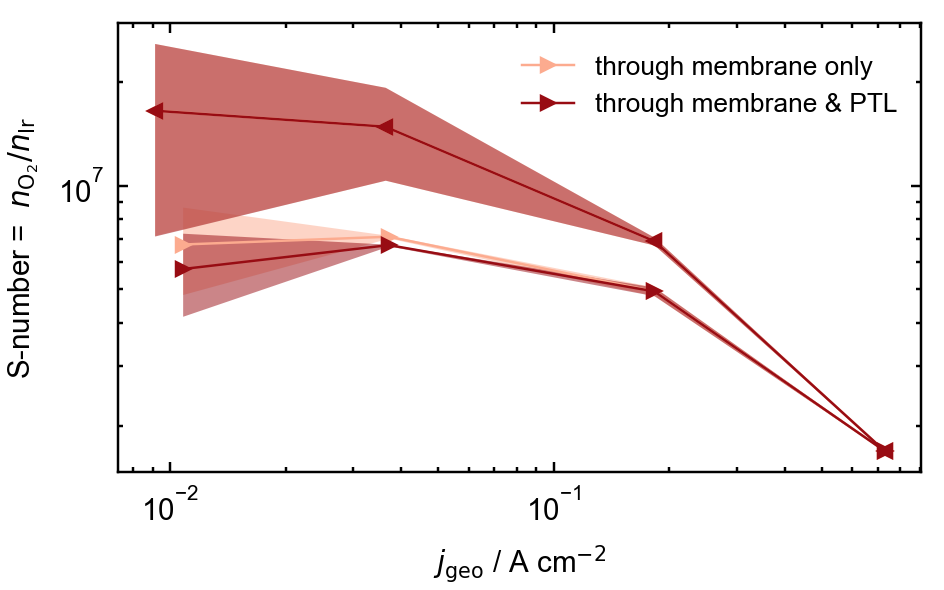

In [35]:
def plot_forward_backward(exp, 
                          x_col, 
                          y_col, 
                          data, 
                          marker_for='>', 
                          marker_back='<', 
                          back_for_col='scan_direction',
                          back_for_crit=1.5, 
                              axlabel_auto=False,
                          **kwarg):
    return exp.dataset.plot(# forward
              y_col=y_col,
              x_col=x_col,
              data=data.loc[data.loc[:, back_for_col]<=back_for_crit],
              marker=marker_for,
        axlabel_auto=False,
             **kwarg
        )\
        .plot(# backward
             y_col=y_col,
             x_col=x_col,
             data=data.loc[data.loc[:, back_for_col]>=back_for_crit],
             marker=marker_back,
            label='',
        axlabel_auto=axlabel_auto,
            **kwarg
        )\
        .return_dataset()

def plot_forward_backward_avg(exp, 
                          x_col, 
                          y_col,
                              ymin_col,
                              ymax_col,
                          data, 
                          marker_for='>', 
                          marker_back='<', 
                          back_for_col='scan_direction',
                          back_for_crit=1.5, 
                              axlabel_auto=False,
                          **kwarg):
    return exp.dataset.fill_between(# forward
              x_col=x_col,
              y_col=ymin_col,
              y2_col=ymax_col,
              data=data.loc[data.loc[:, back_for_col]<=back_for_crit],
              alpha=0.5,
              label='',
        axlabel_auto=False,
        linewidth=0,
             **kwarg
        )\
        .plot(# forward
              x_col=x_col,
              y_col=y_col,
              data=data.loc[data.loc[:, back_for_col]<=back_for_crit],
              marker=marker_for,
                axlabel_auto=False,
             **kwarg
        )\
        .fill_between(# backward
              x_col=x_col,
              y_col=ymin_col,
              y2_col=ymax_col,
             data=data.loc[data.loc[:, back_for_col]>=back_for_crit],
             alpha=0.5,
            label='',
        linewidth=0,
        axlabel_auto=False,
            **kwarg
        )\
        .plot(# backward
             x_col=x_col,
             y_col=y_col,
             data=data.loc[data.loc[:, back_for_col]>=back_for_crit],
             marker=marker_back,
            label='',
        axlabel_auto=axlabel_auto,
            **kwarg
        )\
        .return_dataset()

S_number_calculation_cols = [
                             'S_number_top',
                             'S_number_sum', 
                            ]
labels = ['through membrane only', 'through membrane & PTL']
plot.manual_col_to_axis_label[S_number_calculation_cols[-1]] = 'S-number =  $n_{\mathrm{O}_2} / n_{\mathrm{Ir}}$' 
plot.manual_col_to_axis_label['j__A_cm2geo_fc_bottom_PTL'] = '$j_\mathrm{geo}$ / A cm$^{-2}$' 


data_stability_to_exp_index = list(data_stability_Ir.index.names)
data_stability_to_exp_index.remove('I_step__A')
data_stability_to_exp_index.remove('scan_direction')
exp_stability_Ir = data_stability_Ir.groupby(data_stability_to_exp_index)[['id_spot']].first()
data_stability_to_exp_index.remove('id_spot_diff')
exp_stability_Ir_avg = data_stability_Ir_avg.groupby(data_stability_to_exp_index)[['S_number_sum']].first()


exp_stability_Ir_avg_selected = exp_stability_Ir_avg.loc[lambda row: row.index.get_level_values('id_sample')==179].copy()

x_col_ICPMS='j__A_cm2geo_fc_bottom_PTL'

with plt.rc_context(plot.get_style(style='singleColumn',
                                   interactive=True,
                                   add_margins={'bottom':0.2, }, 
                                  )):
    plot_storage = plot.PlotDataStorage('sfig_polcurve_stability_gravimetric_top_bottom', overwrite_existing=True)
    fig = plt.figure()
    ax = fig.add_subplot(111)

    
    for i, (y_col, 
            colormap_min,
            label,
           ) in enumerate(zip(S_number_calculation_cols,
                              [0.3, 0.9],
                              labels
                                                     )):

        plot_forward_backward_avg(exp_stability_Ir_avg_selected.dataset\
                                                  .add_column('label',
                                                               values=label,
                                                             rowindexer_first_of_group='id_sample')\
                                                        .add_column('color',
                                                               values=['Reds', 'Blues', 'Greens'],
                                                             rowindexers=[exp_stability_Ir_avg_selected.index.get_level_values('id_sample')==179,
                                                                         exp_stability_Ir_avg_selected.index.get_level_values('id_sample')==180,
                                                                         exp_stability_Ir_avg_selected.index.get_level_values('id_sample')==181,],
                                                             cmap_group='id_sample',
                                                             cmap_min=colormap_min,
                                                              cmap_max=0.9,)
                                                  .return_dataset(), 
                          x_col=x_col_ICPMS,
                          y_col=y_col,
                          ymin_col=y_col+'_min',
                          ymax_col=y_col+'_max',
                          data=data_stability_Ir_avg.reset_index('scan_direction'), 
                          marker_for='>', 
                          marker_back='<', 
                          back_for_col='scan_direction',
                          back_for_crit=1.5, 
                          ax=ax,
                          axlabel_auto=True,
                          )


    

    ax.legend(loc='upper right', bbox_to_anchor=(1, 0.98))
    ax.set_xscale('log')
    ax.set_yscale('log')
    


    plot_storage.export(fig, plot_format='pdf')
    plt.show()

# Plot polcurve stability

## Additional EC data

In [36]:
exp_ec_polcurve = db.get_exp('''SELECT  *
                                    FROM hte_data.exp_ec_polcurve_expanded 
                                    WHERE name_user="n.roettcher"
                                     AND name_setup_sfc = "SFC_1"
                                     #AND id_sample = 179
                                     AND DATE(t_start__timestamp) IN ("2024-03-26", "2024-04-03", "2024-04-04")
                                     AND NOT (DATE(t_start__timestamp) IN ("2024-03-26") 
                                                 AND id_sample = 179
                                                 AND id_ML IN (19, 64, 66))
                         ;''',)
    


overlay_cols = ['id_sample', 'id_spot']
df_color = exp_ec_polcurve.reset_index().loc[:, overlay_cols].drop_duplicates()
df_color = df_color.dataset.add_column('color', 
                                            rowindexers=[
                                                        (df_color.id_sample == 179),
                                                        (df_color.id_sample == 180),
                                                         (df_color.id_sample == 181),
                                                        ],
                                            values=['Reds', 'Blues', 'Greens'],
                                           cmap_min=0.3,cmap_max=0.9,)\
                                    .return_dataset()\
                                    .set_index(overlay_cols)


data_ec_polcurve = exp_ec_polcurve.dataset.get_data(con, 'data_ec_polcurve_analysis', add_cond='gooddata=1' )
exp_ec_polcurve.loc[:, 'counts_steps'] =  data_ec_polcurve.reset_index().groupby('id_exp_ec_polcurve').id_data_ec_polcurve.max()

data_ec_polcurve = data_ec_polcurve.join(data_ec_polcurve.groupby(['id_exp_ec_polcurve', 'id_current_step']).id_current_step.count().rename('counts_current_step_in_exp'), on=['id_exp_ec_polcurve', 'id_current_step'])


data_ec_polcurve.loc[((data_ec_polcurve.index.isin(data_ec_polcurve.groupby('id_exp_ec_polcurve').I_hold__A.idxmax().values)) 
                       &(data_ec_polcurve.counts_current_step_in_exp == 1)), 
                     'scan_direction'] = 1.5



exp_ec_polcurve, data_ec_polcurve = tools_ec.gravimetric_current(exp_ec_polcurve, data_ec_polcurve, j_geo_col='j__mA_cm2geo_fc_bottom_PTL')

exp_ec_polcurve.loc[:, 'date'] = pd.to_datetime(exp_ec_polcurve.t_start__timestamp).dt.date
exp_ec_polcurve = exp_ec_polcurve.sort_values(by=['loading__mg_Ir_cm2', 't_start__timestamp']).join(df_color, on=overlay_cols)\
                .dataset.add_column('label', values= exp_ec_polcurve.loading__mg_Ir_cm2.apply(lambda x: '{0:.1f}'.format(x))+' mg$_{\mathrm{Ir}}$ cm$^{-2}$',
                            rowindexer_first_of_group=['id_sample']
                         )\
                .return_dataset()



data_ec_polcurve.loc[:, 'j__A_cm2geo_fc_bottom_PTL'] = data_ec_polcurve.j__mA_cm2geo_fc_bottom_PTL / 1000
data_ec_polcurve.loc[:, 'j__A_mg_Ir_geo_fc_bottom_PTL'] = data_ec_polcurve.j__mA_mg_Ir_geo_fc_bottom_PTL / 1000

data_ec_polcurve = data_ec_polcurve.join(exp_ec_polcurve.loc[:, ['id_sample', 'id_spot', 'counts_steps']], on='id_exp_ec_polcurve')

exp_ec_polcurve_avg, data_ec_polcurve_avg = plot.average(exp_ec_polcurve,#a,# 
                                                        data_ec_polcurve, 
                                                        on=[ 'id_sample', 'counts_steps'],
                                                        name_id_data_overlay_col=['id_data_ec_polcurve'],
                                                        cols_first_value=['color', 'label'],
                                                       )

Link selected experiments to PublicationExport:  HTE09_hCCM_setup
 For table exp_ec_polcurve : inserted new experiments = 0 , skipped existing experiments = 17 
Read data from "data_ec_polcurve_analysis" ...
SELECT * FROM data_ec_polcurve_analysis WHERE (`id_exp_ec_polcurve`) IN (138, 140, 141, 142, 143, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157) AND gooddata=1;
Done in  0:00:00.025803
 j_geo_col is deprecated. Please use the parameter j_geo_cols. 
 green: A single value per group. 
 orange: Different values within the group --> stored as list. 


I__A_std  already in data columns. Will drop the column calculate the std from standard deviation of averaging. Be sure that the previous std is not larger.
E_WE_uncompensated__VvsRHE_std  already in data columns. Will drop the column calculate the std from standard deviation of averaging. Be sure that the previous std is not larger.
Different number of datapoints averaged, check avg_counts column in data dataframe.
   Number of experiments averaged: [5 4 2]


## fig:polcurve_stability_gravimetric

{179: 1.2930746212416436e-13,
 180: 1.2834924048275212e-13,
 181: 1.7472838615978995e-13}

 File  fig_polcurve_stability_gravimetric.pdf  already exists 


Overwrite?
	0: False
	1: True
Your choice:  1


 Plot  fig_polcurve_stability_gravimetric.pdf  successfully saved 
![[Binder_export/Figures/Fig_6_S1_S8_S9_10_S11_S12/fig_polcurve_stability_gravimetric.pdf]] <br> *jupyter notebook source:* ![[Binder_export/Figures/Fig_6_S1_S8_S9_10_S11_S12/$$dummy_replaced_by_obsidian_jupyter$$]]


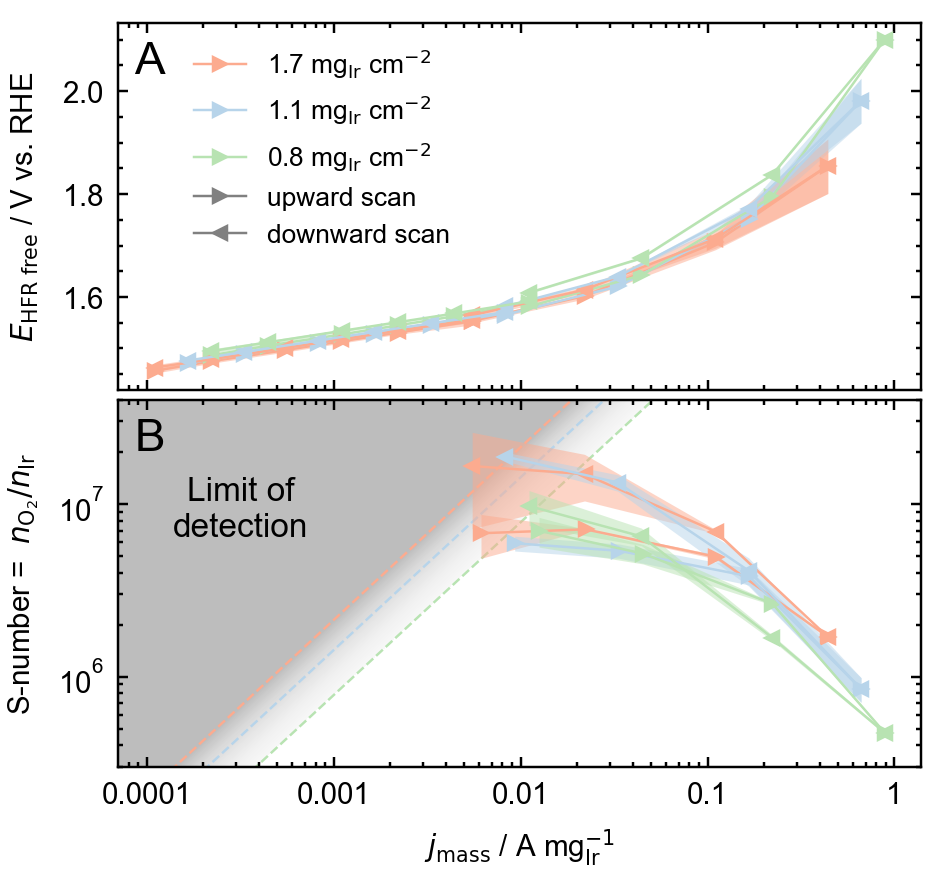

In [37]:
plot.manual_col_to_axis_label['j__A_mg_Ir_geo_fc_bottom_PTL'] = '$j_\mathrm{mass}$ / A mg$_{\mathrm{Ir}}^{-1}$' 
plot.manual_col_to_axis_label['S_number_trapz'] = 'S-number =  $n_{\mathrm{O}_2} / n_{\mathrm{Ir}}$'
plot.manual_col_to_axis_label['S_number_top'] = 'S-number =  $n_{\mathrm{O}_2} / n_{\mathrm{Ir}}$' 
plot.manual_col_to_axis_label['E_WE__VvsRHE'] = '$E_{\\mathrm{HFR\\ free}}$ / V vs. RHE'


x_col_EC_ICPMS='j__A_mg_Ir_geo_fc_bottom_PTL'
y_col_EC = 'E_WE__VvsRHE'
y_col_ICPMS='S_number_top'


with plt.rc_context(plot.get_style(style='singleColumn',
                                   increase_fig_height=1.5,
                                   interactive=True,
                                   add_margins={'bottom':0.2, },
                                  )):
    plot_storage = plot.PlotDataStorage('fig_polcurve_stability_gravimetric', overwrite_existing=True)
    fig = plt.figure()

    gs = gridspec.GridSpec(2, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    plt.setp(ax1.get_xticklabels(), visible=False)
    axs = [ax1, ax2]



    plot_forward_backward_avg(exp_ec_polcurve_avg, 
                  x_col=x_col_EC_ICPMS,
                  y_col=y_col_EC,
                  ymin_col=y_col_EC+'_min',
                  ymax_col=y_col_EC+'_max',
                  data=data_ec_polcurve_avg, 
                  marker_for='>', 
                  marker_back='<', 
                  back_for_col='scan_direction',
                  back_for_crit=1.5, 
                  ax=ax1,
                              axlabel_auto=True,
                  )

    plot_forward_backward_avg(exp_stability_Ir_avg.dataset\
                                                .add_column('color',
                                                       values=['Reds', 'Blues', 'Greens'],
                                                     rowindexers=[exp_stability_Ir_avg.index.get_level_values('id_sample')==179,
                                                                 exp_stability_Ir_avg.index.get_level_values('id_sample')==180,
                                                                 exp_stability_Ir_avg.index.get_level_values('id_sample')==181,],
                                                     cmap_group='id_sample',
                                                     cmap_min=0.3,cmap_max=0.9,)\
                                          .return_dataset(), 
                  x_col=x_col_EC_ICPMS, 
                  y_col=y_col_ICPMS,
                  ymin_col=y_col_ICPMS+'_min',
                  ymax_col=y_col_ICPMS+'_max',
                  data=data_stability_Ir_avg.reset_index('scan_direction'), 
                  marker_for='>', 
                  marker_back='<', 
                  back_for_col='scan_direction',
                  back_for_crit=1.5, 
                  ax=ax2,
                          axlabel_auto=True,
                  )

    
    handles, labels = ax1.get_legend_handles_labels()
    handles += [plot.legend_handle_line(marker='>', color='grey'),
                plot.legend_handle_line(marker='<', color='grey'),
               ]
    labels += ['upward scan',
               'downward scan'
              ]


    plot_labels = list(string.ascii_uppercase)[:len(axs)]

    for ax, plot_label in zip(axs, plot_labels):
        ax.text(0.02, 0.95, plot_label, 
                    horizontalalignment='left', 
                    verticalalignment='top', 
                    transform=ax.transAxes,
                    fontsize=11)

    
    
    
    
    ax1.set_xscale('log')
    ax2.set_yscale('log')
    ax2.xaxis.set_major_formatter(lambda x, pos: ("%.8f" %x).rstrip('.0'))
    
    ax1.set_xlabel('')


    ax1.legend(handles, labels , loc='upper left', bbox_to_anchor=(0.065, 1.0))
    ax2.set_ylim([0.3e6, 4e7])

    
    #######
    # grey box for detection limit, three areas
    #######
    
    # 1. gray:      below 3sigma detection limit for all loadings
    # 2. grayscale: 3sigma detection limit difference bteween the measured loadings
    # 3. white:     above the 3sigma detection for all loadings
    # dissolution rate can be referred to S-number
    # detection limit is 3*standard deviation of noise in dissolution signal --> dm_dt_S_std__g_s_cm2 (from dissolution profile)
    
    ax2_xlims = ax2.get_xlim()
    ax2_ylims = ax2.get_ylim()
    M_Ir__g_mol = 192.22
    z = 4
    F__C_mol = scipy.constants.physical_constants['Faraday constant'][0]

    # sample specific detection limit
    dm_dt_S_std__g_s_cm2 = {id_sample: dm_dt_S_std_allexp__g_s_cm2.loc[lambda row: ((row.index.get_level_values('id_sample')==id_sample) 
                                                                                     & (row.index.get_level_values('icpms_location')=='top'))].max() 
                            for id_sample in exp_icpms_overlay.index.get_level_values('id_sample').unique().tolist()}
    display(dm_dt_S_std__g_s_cm2)
    m_Ir_loading_max__mg_cm2 = exp_icpms_overlay.loading__mg_Ir_cm2.max()#min() # detection limit in terms of gravimetric higher for lower loadings, but difficult to display in one plot
    factor_std_signal = 3


    # Create a meshgrid over the whole plot
    x = np.logspace(np.log10(ax2_xlims[0])-1, np.log10(ax2_xlims[1])+1, 500)
    y = np.logspace(np.log10(ax2_ylims[0])-1, np.log10(ax2_ylims[1])+1, 500)
    X, Y = np.meshgrid(x, y)
    
    # Define slope of borders
    def limit_slope_grav(m_Ir_loading__mg_cm2, 
                    M_Ir__g_mol, 
                    z, 
                    F__C_mol,
                    dm_dt_S_std__g_s_cm2,
                   ):
        # should return unit: mg / A
        # from S_number definition: S = nO2 / nIr = M(Ir) * loading(Ir) / (z * F * dm_dt_S) * j_mass
        return m_Ir_loading__mg_cm2 * M_Ir__g_mol / (z * F__C_mol * dm_dt_S_std__g_s_cm2)
    
    limit_slope_max = limit_slope_grav(exp_icpms_overlay.loading__mg_Ir_cm2.max(), M_Ir__g_mol, z, F__C_mol,dm_dt_S_std__g_s_cm2[exp_icpms_overlay.loading__mg_Ir_cm2.idxmax()[0]],)
    limit_slope_min = limit_slope_grav(exp_icpms_overlay.loading__mg_Ir_cm2.min(), M_Ir__g_mol, z, F__C_mol,dm_dt_S_std__g_s_cm2[exp_icpms_overlay.loading__mg_Ir_cm2.idxmin()[0]],)
    
    limit_min = Y / (limit_slope_min * X ) 
    limit_max = Y / (limit_slope_max * X ) 

    # Define border white--grayscale as mask for the box
    mask = limit_min >= (1 / factor_std_signal) 

    # Define border grayscale--gray
    cmap_val = limit_max
    #cmap_val[limit_max > 1] = 1 # constant gray color for dissolution rates below standard deviation, color gradient only for condition 2
    cmap_val[limit_max >= (1 / factor_std_signal) ] = 1/ factor_std_signal # constant gray color for dissolution rates below 3sigma of maximum loading, color gradient only for condition 2
    # constant color should be the same value as given by the limit of maximum loading
    
    
    # Apply the mask to ensure we only plot points fulfilling condition 1 or 2
    # adjust grayscale more smoothly
    cmap_gradient = np.ma.masked_where(~mask, cmap_val)

    
    
    
    text_y_percent = 0.7
    text_x_percent = 0.5
    text_y_axes = 10**(np.log10(ax2_ylims[0]) + (np.log10(ax2_ylims[1])-np.log10(ax2_ylims[0]))*text_y_percent)
    text_x_axes = 10**(np.log10(ax2_xlims[0]) + (np.log10(text_y_axes/limit_slope_max)-np.log10(ax2_xlims[0]))*text_x_percent)

    
    ax2.text(text_x_axes, # transform data coordinates to Axes coordinates for x-coordinate between xlim_min and detection limit
             text_y_axes,
             "Limit of\ndetection", 
             #transform=ax2.transAxes, 
             fontsize=8,
             #verticalalignment='top', 
             #bbox=props
             ha='center',
             va='center',
             ma='center',
            )
    
    # plot borders
    for id_sample, row in exp_ec_polcurve_avg.groupby('id_sample')[['color', 'loading__mg_Ir_cm2']].first().iterrows():
        line, = ax2.plot(x,  
                         (limit_slope_grav(row.loading__mg_Ir_cm2, M_Ir__g_mol, z, F__C_mol,dm_dt_S_std__g_s_cm2[id_sample],)/factor_std_signal * x), 
                         color=row.color,
                        linestyle='--',
                        zorder=0.1)
    
    # plot box
    ax2.contourf(X, 
                 Y, 
                 cmap_gradient, 
                 100, cmap='Greys',
                 vmax=cmap_gradient.max()+(cmap_gradient.max() - cmap_gradient.min())*2, # gray tone
                 vmin=cmap_gradient.min()-(cmap_gradient.max() - cmap_gradient.min())*0.2, # lightes gray in colorcode
                zorder=0)

    ax2.set_ylim(ax2_ylims)
    ax2.set_xlim(ax2_xlims)


    fig.align_ylabels(axs)

    plot_storage.export(fig, plot_format='pdf')
    plt.show()

## sfig:polcurve_stability_geometric

/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/visualization/plot.py:3230: UserWarning: weakly reference error, all PlotDataStorage objects are deleted.
  warnings.warn(


 File  sfig_polcurve_stability_geometric.pdf  already exists 


Overwrite?
	0: False
	1: True
Your choice:  1


 Plot  sfig_polcurve_stability_geometric.pdf  successfully saved 
![[Binder_export/Figures/Fig_6_S1_S8_S9_10_S11_S12/sfig_polcurve_stability_geometric.pdf]] <br> *jupyter notebook source:* ![[Binder_export/Figures/Fig_6_S1_S8_S9_10_S11_S12/$$dummy_replaced_by_obsidian_jupyter$$]]


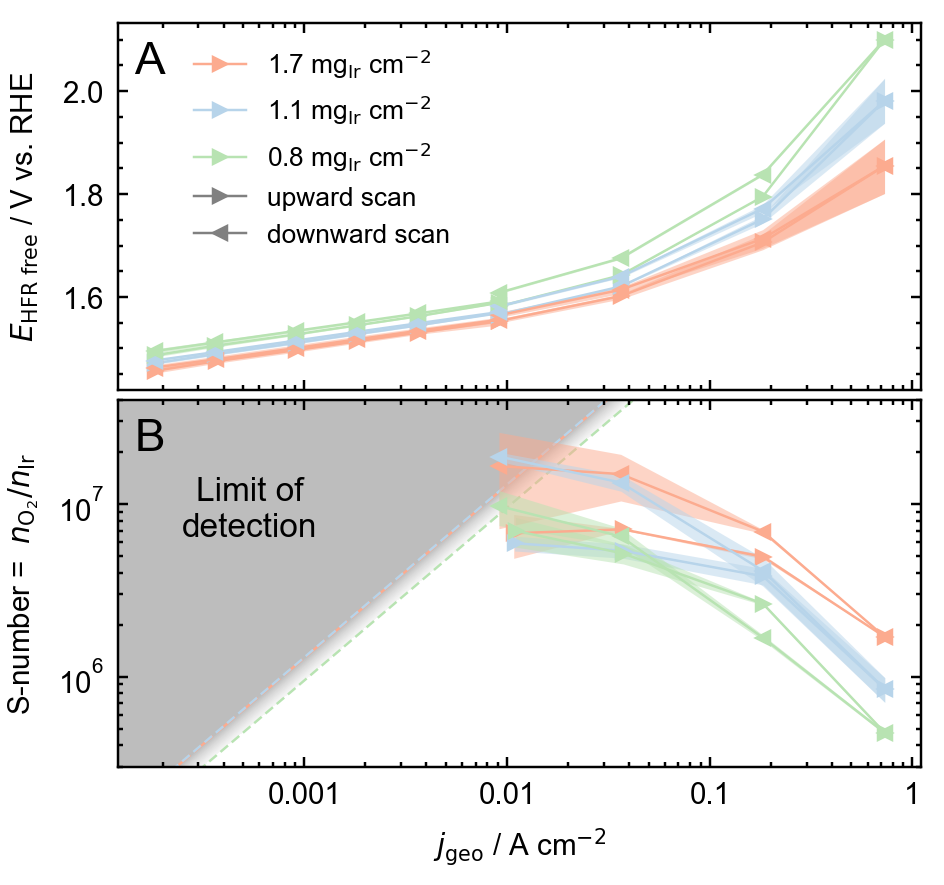

In [38]:
plot.manual_col_to_axis_label['j__A_cm2geo_fc_bottom_PTL'] = '$j_\mathrm{geo}$ / A cm$^{-2}$'
plot.manual_col_to_axis_label['S_number_trapz'] = 'S-number =  $n_{\mathrm{O}_2} / n_{\mathrm{Ir}}$' 
plot.manual_col_to_axis_label['E_WE__VvsRHE'] = '$E_{\\mathrm{HFR\\ free}}$ / V vs. RHE'


x_col_EC_ICPMS='j__A_cm2geo_fc_bottom_PTL'
y_col_EC = 'E_WE__VvsRHE'
y_col_ICPMS='S_number_top'


with plt.rc_context(plot.get_style(style='singleColumn',
                                   increase_fig_height=1.5,
                                   interactive=True,
                                   add_margins={'bottom':0.2, }, 
                                  )):
    plot_storage = plot.PlotDataStorage('sfig_polcurve_stability_geometric', overwrite_existing=True)
    fig = plt.figure()

    gs = gridspec.GridSpec(2, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    plt.setp(ax1.get_xticklabels(), visible=False)
    axs = [ax1, ax2]


    
    plot_forward_backward_avg(exp_ec_polcurve_avg, 
                  x_col=x_col_EC_ICPMS,
                  y_col=y_col_EC,
                  ymin_col=y_col_EC+'_min',
                  ymax_col=y_col_EC+'_max',
                  data=data_ec_polcurve_avg, 
                  marker_for='>', 
                  marker_back='<', 
                  back_for_col='scan_direction',
                  back_for_crit=1.5, 
                  ax=ax1,
                  axlabel_auto=True,
                  )


    
    plot_forward_backward_avg(exp_stability_Ir_avg.dataset\
                                                .add_column('color',
                                                       values=['Reds', 'Blues', 'Greens'],
                                                     rowindexers=[exp_stability_Ir_avg.index.get_level_values('id_sample')==179,
                                                                 exp_stability_Ir_avg.index.get_level_values('id_sample')==180,
                                                                 exp_stability_Ir_avg.index.get_level_values('id_sample')==181,],
                                                     cmap_group='id_sample',
                                                     cmap_min=0.3,cmap_max=0.9,)\
                                          .return_dataset(), 
                  x_col=x_col_EC_ICPMS,
                  y_col=y_col_ICPMS,
                  ymin_col=y_col_ICPMS+'_min',
                  ymax_col=y_col_ICPMS+'_max',
                  data=data_stability_Ir_avg.reset_index('scan_direction'), 
                  marker_for='>', 
                  marker_back='<', 
                  back_for_col='scan_direction',
                  back_for_crit=1.5, 
                  ax=ax2,
                              axlabel_auto=True,
                  )


    handles, labels = ax1.get_legend_handles_labels()
    handles += [plot.legend_handle_line(marker='>', color='grey'),
                plot.legend_handle_line(marker='<', color='grey'),
               ]
    labels += ['upward scan',
               'downward scan'
              ]

    plot_labels = list(string.ascii_uppercase)[:len(axs)]

    for ax, plot_label in zip(axs, plot_labels):
        ax.text(0.02, 0.95, plot_label, 
                    horizontalalignment='left', 
                    verticalalignment='top', 
                    transform=ax.transAxes,
                    fontsize=11)

    
    
    
    
    ax1.set_xscale('log')
    ax2.set_yscale('log')
    ax2.xaxis.set_major_formatter(lambda x, pos: ("%.8f" %x).rstrip('.0'))
    
    ax1.set_xlabel('')


    ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.065, 1.0))
    ax2.set_ylim([0.3e6, 4e7])


    #######
    # grey box for detection limit, three areas
    #######
    
    # 1. gray:      below 3sigma detection limit for all loadings
    # 2. grayscale: 3sigma detection limit difference bteween the measured loadings
    # 3. white:     above the 3sigma detection for all loadings
    # dissolution rate can be referred to S-number
    # detection limit is 3*standard deviation of noise in dissolution signal --> dm_dt_S_std__g_s_cm2 (from dissolution profile)
    
    
    ax2_xlims = ax2.get_xlim()
    ax2_ylims = ax2.get_ylim()
    M_Ir__g_mol = 192.22
    z = 4
    F__C_mol = scipy.constants.physical_constants['Faraday constant'][0]
    #dm_dt_min__g_s = 0.04e-12 # 0.04 pg/s
    #dm_dt_S_std__g_s_cm2 = dm_dt_S_std_allexp__g_s_cm2.max() # ~0.0001 ng/(s cm2) # choose the maximum standard deviation of all experiments
    dm_dt_S_std__g_s_cm2 = {id_sample: dm_dt_S_std_allexp__g_s_cm2.loc[lambda row: ((row.index.get_level_values('id_sample')==id_sample) 
                                                                                     & (row.index.get_level_values('icpms_location')=='top'))].max() 
                            for id_sample in exp_icpms_overlay.index.get_level_values('id_sample').unique().tolist()}
    m_Ir_loading_max__mg_cm2 = exp_icpms_overlay.loading__mg_Ir_cm2.max()#min() # detection limit in terms of gravimetric higher for lower loadings, but difficult to display in one plot
    factor_std_signal = 3


    # Create a meshgrid over the whole plot
    x = np.logspace(np.log10(ax2_xlims[0])-1, np.log10(ax2_xlims[1])+1, 500)
    y = np.logspace(np.log10(ax2_ylims[0])-1, np.log10(ax2_ylims[1])+1, 500)
    X, Y = np.meshgrid(x, y)
    
    # Define slope of borders
    def limit_slope_geo(
                    M_Ir__g_mol, 
                    z, 
                    F__C_mol,
                    dm_dt_S_std__g_s_cm2,
                   ):
        # should return unit: mg / A
        # from S_number definition: S = nO2 / nIr = M(Ir) / (z * F * dm_dt_S) * j_geo
        return  M_Ir__g_mol / (z * F__C_mol * dm_dt_S_std__g_s_cm2)
    
    #limit_slope_max = limit_slope_geo(M_Ir__g_mol, z, F__C_mol,dm_dt_S_std__g_s_cm2,)
    limit_slope_max = limit_slope_geo(M_Ir__g_mol, z, F__C_mol,dm_dt_S_std__g_s_cm2[exp_icpms_overlay.loading__mg_Ir_cm2.idxmax()[0]],)
    limit_slope_min = limit_slope_geo(M_Ir__g_mol, z, F__C_mol,dm_dt_S_std__g_s_cm2[exp_icpms_overlay.loading__mg_Ir_cm2.idxmin()[0]],)
    
    limit_min = Y / (limit_slope_min * X ) 
    limit_max = Y / (limit_slope_max * X ) 

    # Define border white--grayscale as mask for the box
    mask = limit_min >= (1 / factor_std_signal) 

    # Define border grayscale--gray
    cmap_val = limit_max
    #cmap_val[limit_max > 1] = 1 # constant gray color for dissolution rates below standard deviation, color gradient only for condition 2
    cmap_val[limit_max >= (1 / factor_std_signal) ] = 1/ factor_std_signal # constant gray color for dissolution rates below 3sigma of maximum loading, color gradient only for condition 2
    # constant color should be the same value as given by the limit of maximum loading
    
    # Apply the mask to ensure we only plot points fulfilling condition 1 or 2
    # adjust grayscale more smoothly
    cmap_gradient = np.ma.masked_where(~mask, cmap_val)

    
    
    
    text_y_percent = 0.7
    text_x_percent = 0.5
    text_y_axes = 10**(np.log10(ax2_ylims[0]) + (np.log10(ax2_ylims[1])-np.log10(ax2_ylims[0]))*text_y_percent)
    text_x_axes = 10**(np.log10(ax2_xlims[0]) + (np.log10(text_y_axes/limit_slope_max)-np.log10(ax2_xlims[0]))*text_x_percent)

    
    ax2.text(text_x_axes, # transform data coordinates to Axes coordinates for x-coordinate between xlim_min and detection limit
             text_y_axes,
             "Limit of\ndetection", 
             #transform=ax2.transAxes, 
             fontsize=8,
             #verticalalignment='top', 
             #bbox=props
             ha='center',
             va='center',
             ma='center',
            )
    
    # plot borders
    for id_sample, row in exp_ec_polcurve_avg.groupby('id_sample')[['color', 'loading__mg_Ir_cm2']].first().iterrows():
        line, = ax2.plot(x,  
                         (limit_slope_geo(M_Ir__g_mol, z, F__C_mol,dm_dt_S_std__g_s_cm2[id_sample],)/factor_std_signal * x), 
                         color=row.color,
                        linestyle='--',
                         dashes=[10,2] if int(id_sample) == 179 else [4,2],
                        zorder=0.1)

    ax2.contourf(X, 
                 Y, 
                 cmap_gradient, 
                 100, cmap='Greys',
                 vmax=cmap_gradient.max()+(cmap_gradient.max() - cmap_gradient.min())*2,
                 vmin=cmap_gradient.min()-(cmap_gradient.max() - cmap_gradient.min())*0.2,
                zorder=0)
    
    
    
    ax2.set_ylim(ax2_ylims)
    ax2.set_xlim(ax2_xlims)
    

    fig.align_ylabels(axs)

    plot_storage.export(fig, plot_format='pdf')
    plt.show()

# Literature data

In [39]:
exp_lit = pd.read_csv('literature_data/exp_Geiger_Pham_Geuss_Dam.csv', index_col=['id_exp'], encoding = "latin").sort_values(by=['author', 'material'])
data_lit = pd.read_csv('literature_data/data_Geiger_Pham_Geuss_Dam.csv', index_col=['id_exp', 'id_data'])



exp_lit = exp_lit.loc[( (exp_lit.author == 'Geuss') 
                        | (exp_lit.author == 'Pham')   & (exp_lit.protocol == 'hold') 
                        | (exp_lit.author == 'Dam') 
                        | (exp_lit.author == 'Geiger') & (exp_lit.sample_type=='powder thin film') 
                      ), :]

def plot_polcurve_stability_literature(plot_name,
                                       exp_stability_Ir,
                                       x_col_EC_ICPMS, 
                                       x_col_Lit,
                                       y_col_ICPMS='S_number_top',
                                       y_col_Lit='S_number',
                                      ):
    x_col_EC_ICPMS=x_col_EC_ICPMS
    x_col_Lit=x_col_Lit



    with plt.rc_context(plot.get_style(style='doubleColumn',
                                       increase_fig_height=1,
                                       interactive=True,
                                       add_margins={'bottom':0.2, 'right':7, 'left':3}, 
                                      )):
        plot_storage = plot.PlotDataStorage(plot_name, overwrite_existing=True)
        fig = plt.figure()
        gs = gridspec.GridSpec(1, 1)
        ax1 = fig.add_subplot(gs[0, 0])
        
        # This work
        ax_stability = ax1
        # yellow dots
        exp_stability_Ir = exp_stability_Ir.dataset\
                    .add_column('label',
                                values='This work, IrO$_2$/TiO$_2$, h-CCM',
                                rowindexer_first_of_group=['name_isotope_analyte']
                               )\
                    .plot(x_col=x_col_EC_ICPMS,
                              y_col=y_col_ICPMS,
                              data=data_stability_Ir,
                            ax=ax_stability,
                              marker='.',
                          color='gold',
                          linestyle='',
                             )\
        .return_dataset()


        # Literature
        exp_lit.dataset.add_column('label', 
                                   values=exp_lit.author.str.replace('ss', 'ß') + ' et al.' 
                                           + ', ' + exp_lit.material.str.replace('2', '$_2$').str.replace('x', '$_x$')
                                           + ([', ' + str(val) + ' °C' if ~np.isnan(val) else '' for val in exp_lit.T__degreeC.values])
                                           + ', ' + exp_lit.sample_type,
                                   rowindexer_first_of_group=['author', 'material', 'T__degreeC']
                                  )\
                        .add_column('color', 
                                   values=['gold',  'lightcoral', 'orange',],
                                   rowindexers=[exp_lit.material=='IrO2/TiO2',
                                               exp_lit.material=='IrOx',
                                                exp_lit.material=='IrO2',
                                               ]
                                  )\
                            .add_column('marker', 
                                   values=['h', '*', 'x', 'p', '1'],
                                   rowindexers=[((exp_lit.author=='Geuss') & (exp_lit.T__degreeC==20)),
                                                ((exp_lit.author=='Geuss') & (exp_lit.T__degreeC==60)),
                                               exp_lit.author=='Pham',
                                                exp_lit.author=='Dam',
                                                exp_lit.author=='Geiger',
                                               ]
                                  )\
                                .add_column('markeredgecolor', 
                                   values=['black', ],
                                   rowindexers=[exp_lit.author=='Geuss',],
                                  )\
                                .add_column('markeredgewidth', 
                                   values=[0.3, ],
                                   rowindexers=[exp_lit.author=='Geuss',],
                                  )\
                                .add_column('markersize', 
                                   values=[2, 4, 3, 4],
                                   rowindexers=[((exp_lit.author=='Geuss') & (exp_lit.protocol=='hold1')),
                                                ((exp_lit.author=='Geuss') & (exp_lit.T__degreeC=='hold2')),
                                               exp_lit.marker.isin(['p', 'x']),
                                                exp_lit.marker.isin(['1']),
                                               ]
                                  )\
                                .add_column('zorder', 
                                   values=[2, 4, 5, 2],
                                   rowindexers=[((exp_lit.author=='Geuss') & (exp_lit.T__degreeC==20)),
                                                ((exp_lit.author=='Geuss') & (exp_lit.T__degreeC==60)),
                                               exp_lit.author=='Geiger',
                                                ~exp_lit.author.isin(['Geuss','Geiger']),
                                               ]
                                  )\
                    .plot(x_col=x_col_Lit,
                          y_col=y_col_Lit,
                          data=data_lit,
                          linewidth=0,
                          axlabel_auto=False
                         )

        # Add arrows
        df_geuss = exp_lit.loc[lambda self: self.author=='Geuss'].join(data_lit.reset_index('id_data', drop=True), on='id_exp', how='left')

        for j_grav, T in zip([0.1, 1, 1], [20,20,60]):
            x=j_grav
            y=df_geuss.loc[lambda self: ((self.protocol=='hold1') 
                                         & (self.j_grav__A_mgIr==j_grav)
                                           & (self.T__degreeC==T)
                                        )].S_number.values[0]
            dx=0
            y2=df_geuss.loc[lambda self: ((self.protocol=='hold2') 
                                         & (self.j_grav__A_mgIr==j_grav)
                                           & (self.T__degreeC==T)
                                        )].S_number.values[0]

            opt = dict(color='black', 
                        arrowstyle = 'simple,head_width=.75,head_length=.55',
                      )
            ax1.annotate('', 
                         xy=(x, y2),
                         xycoords='data',
                         xytext =(x, y),
                         arrowprops=opt,
                         size=3,
                         zorder=4,
                        )

        ax1.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        plot.log_axis_yticklabel(ax1,
                        one_label_per_order=True,
                        style='scientific',
                        strip_decimal_0=True,
                        )
        plot_storage.export(fig, plot_format='pdf')
        plt.show()

## sfig:polcurve_stability_gravimetric_literature

/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/visualization/plot.py:2005: UserWarning: markeredgecolor not specified for 14
  warnings.warn(param_name + " not specified for " + str(index))
/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/visualization/plot.py:2005: UserWarning: markeredgewidth not specified for 14
  warnings.warn(param_name + " not specified for " + str(index))
/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/visualization/plot.py:2005: UserWarning: markeredgecolor not specified for 2
  warnings.warn(param_name + " not specified for " + str(index))
/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/visualization/plot.py:2005: UserWarning: markeredgewidth not specified for 2
  warnings.warn(param_name + " not specified for " + str(index))
/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/visualization/plot.py:2005: UserWarning: markeredgecolor not specified for 3
  warnings.warn(param_name + " not specified for " + 

scientific should be default, if not to be developed
 File  sfig_polcurve_stability_gravimetric_literature.pdf  already exists 


Overwrite?
	0: False
	1: True
Your choice:  1


 Plot  sfig_polcurve_stability_gravimetric_literature.pdf  successfully saved 
![[Binder_export/Figures/Fig_6_S1_S8_S9_10_S11_S12/sfig_polcurve_stability_gravimetric_literature.pdf]] <br> *jupyter notebook source:* ![[Binder_export/Figures/Fig_6_S1_S8_S9_10_S11_S12/$$dummy_replaced_by_obsidian_jupyter$$]]


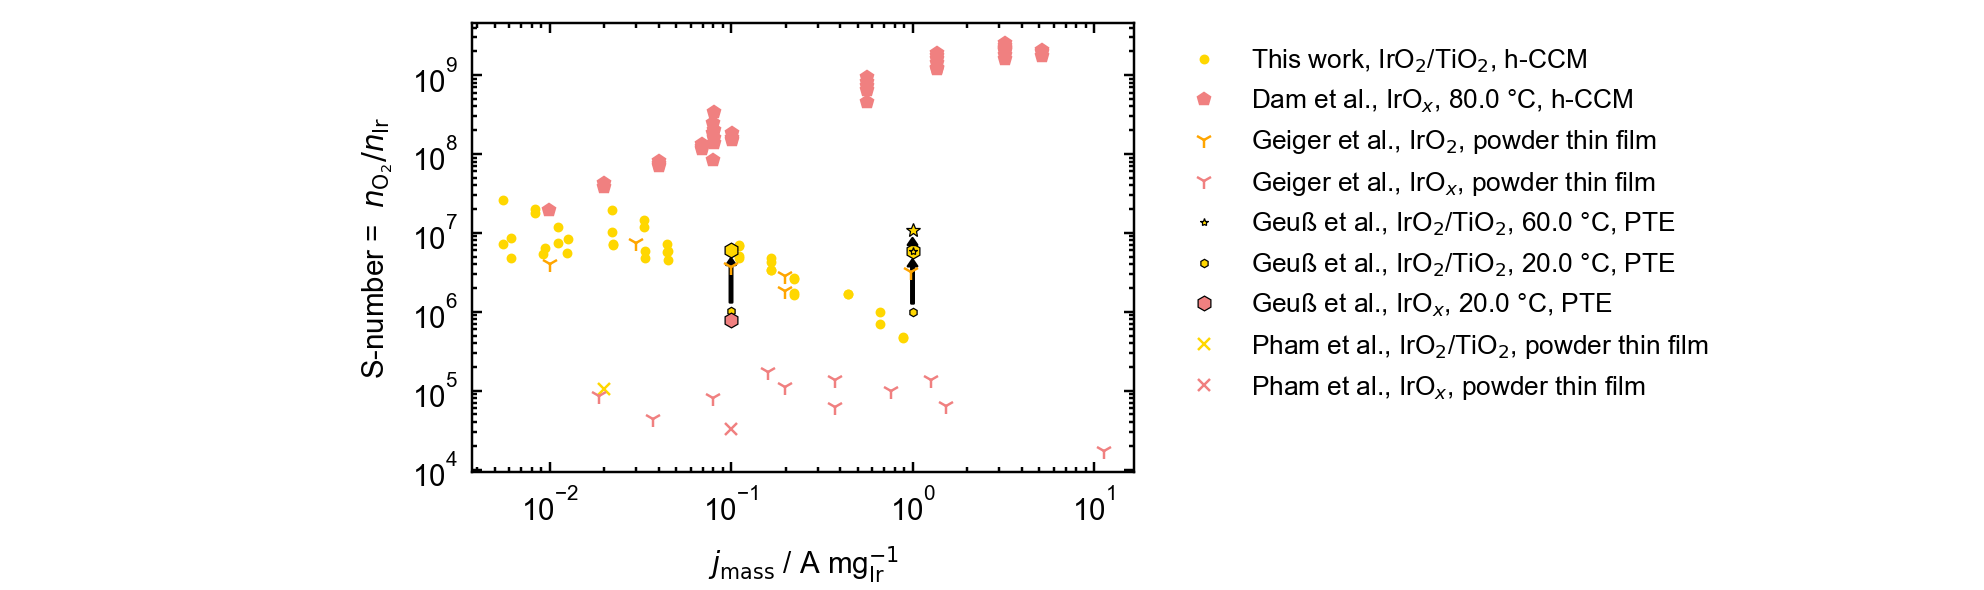

In [40]:
plot.manual_col_to_axis_label['j__A_mg_Ir_geo_fc_bottom_PTL'] = '$j_\mathrm{mass}$ / A mg$_{\mathrm{Ir}}^{-1}$'
plot.manual_col_to_axis_label['S_number_top'] = 'S-number =  $n_{\mathrm{O}_2} / n_{\mathrm{Ir}}$'

plot_polcurve_stability_literature(plot_name='sfig_polcurve_stability_gravimetric_literature',
                                   exp_stability_Ir=exp_stability_Ir,
                                   x_col_EC_ICPMS='j__A_mg_Ir_geo_fc_bottom_PTL',
                                   x_col_Lit='j_grav__A_mgIr',
                                   y_col_ICPMS='S_number_top',
                                   y_col_Lit='S_number',
                                  )
    

# Polcurve 2, sfig:dis_pro_select_data_Snumber_polcurve2

Read data from "exp_ec_datasets_definer" ...
SELECT * FROM exp_ec_datasets_definer WHERE (`id_exp_ec_dataset`) IN (252, 254);
Done in  0:00:00.013306
Link selected experiments to PublicationExport:  HTE09_hCCM_setup
 For table exp_ec_datasets_definer : inserted new experiments = 0 , skipped existing experiments = 48 
Read data from "exp_ec_expanded" ...
SELECT * FROM exp_ec_expanded WHERE (`id_exp_sfc`) IN (12878, 12879, 12880, 12881, 12882, 12883, 12884, 12885, 12886, 12887, 12888, 12889, 12890, 12891, 12892, 12893, 12894, 12895, 12896, 12897, 12898, 12899, 12900, 12901, 13072, 13073, 13074, 13075, 13076, 13077, 13078, 13079, 13080, 13081, 13082, 13083, 13084, 13085, 13086, 13087, 13088, 13089, 13090, 13091, 13092, 13093, 13094, 13095);
Done in  0:00:00.032845
Link selected experiments to PublicationExport:  HTE09_hCCM_setup
 For table exp_sfc : inserted new experiments = 0 , skipped existing experiments = 48 
SELECT id_exp_sfc, t_start__timestamp,t_end__timestamp, id_exp_icpms, spots

/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/processing/tools_ec.py:964: UserWarning: Column: "j__mA_cm2geo_active_chosen" not available in data_ec. Will be skipped.
  warnings.warn(f'Column: "{col}" not available in data_ec. Will be skipped.')


SELECT id_exp_sfc, t_start__timestamp,t_end__timestamp, id_exp_icpms, spots_spot_size__mm2  FROM match_exp_sfc_exp_icpms m   
           WHERE (id_exp_sfc)   IN (12878, 12879, 12880, 12881, 12882, 12883, 12884, 12885, 12886, 12887, 12888, 12889, 12890, 12891, 12892, 12893, 12894, 12895, 12896, 12897, 12898, 12899, 12900, 12901, 13072, 13073, 13074, 13075, 13076, 13077, 13078, 13079, 13080, 13081, 13082, 13083, 13084, 13085, 13086, 13087, 13088, 13089, 13090, 13091, 13092, 13093, 13094, 13095);
Added snychronized timestamp column:  Timestamp_synchronized__s
Added snychronized timestamp column:  t_delaycorrected__timestamp_sfc_pc_synchronized__s


/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/visualization/plot.py:3230: UserWarning: weakly reference error, all PlotDataStorage objects are deleted.
  warnings.warn(


 File  sfig_dis_pro_select_data_Snumber_polcurve2.pdf  already exists 


Overwrite?
	0: False
	1: True
Your choice:  1


 Plot  sfig_dis_pro_select_data_Snumber_polcurve2.pdf  successfully saved 
![[Binder_export/Figures/Fig_6_S1_S8_S9_10_S11_S12/sfig_dis_pro_select_data_Snumber_polcurve2.pdf]] <br> *jupyter notebook source:* ![[Binder_export/Figures/Fig_6_S1_S8_S9_10_S11_S12/$$dummy_replaced_by_obsidian_jupyter$$]]


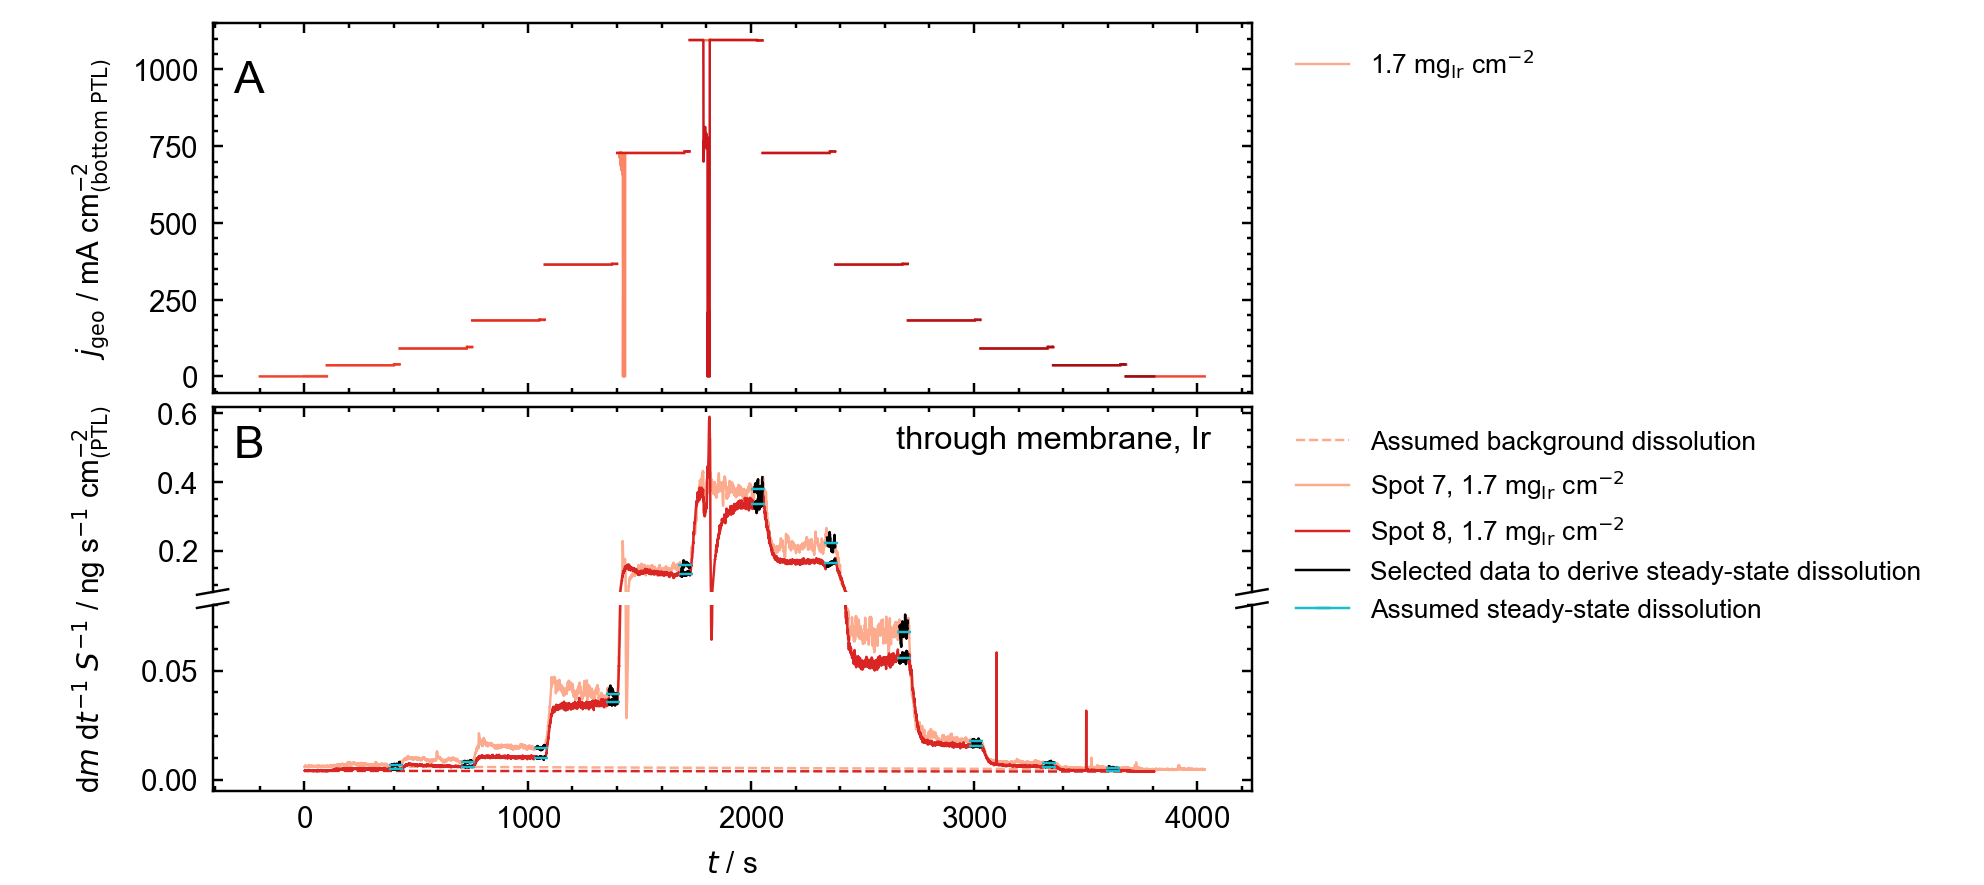

id_spot  \
id_sample id_spot_diff name_isotope_analyte name_isotope_internalstandard scan_direction I_step__A            
179       0            Ir193                Re187                         1.0            0.002            7   
                                                                                         0.005            7   
                                                                                         0.010            7   
                                                                                         0.020            7   
                                                                                         0.040            7   
                                                                          1.5            0.060            7   
                                                                          2.0            0.002            7   
                                                                                         0.005            7   
                                                                                         0.010            7   
                                                                                         0.020            7   
                                                                                         0.040            7   
          1            Ir193                Re187                         1.0            0.002            8   
                                                                                         0.005            8   
                                                                                         0.010            8   
                                                                                         0.020            8   
                                                                                         0.040            8   
                                                                          1.5            0.060            8   
                                                                          2.0            0.002            8   
                                                                                         0.005            8   
                                                                                         0.010            8   
                                                                                         0.020            8   
                                                                                         0.040            8   

                                                                                                        I__A  \
id_sample id_spot_diff name_isotope_analyte name_isotope_internalstandard scan_direction I_step__A             
179       0            Ir193                Re187                         1.0            0.002      0.002033   
                                                                                         0.005      0.005060   
                                                                                         0.010      0.010044   
                                                                                         0.020      0.020052   
                                                                                         0.040      0.040077   
                                                                          1.5            0.060      0.060201   
                                                                          2.0            0.002      0.002001   
                                                                                         0.005      0.005069   
                                                                                         0.010      0.010047   
                                                                                         0.020      0.020052   
                                                                                         0.

S_number_top  \
id_sample name_isotope_analyte name_isotope_internalstandard scan_direction I_step__A                 
179       Ir193                Re187                         1.0            0.002      2.158240e+07   
                                                                            0.005      2.041587e+07   
                                                                            0.010      1.248411e+07   
                                                                            0.020      5.546507e+06   
                                                                            0.040      2.607695e+06   
                                                             1.5            0.060      1.557361e+06   
                                                             2.0            0.002      3.258214e+07   
                                                                            0.005      1.787223e+07   
                                                                            0.010      7.479987e+06   
                                                                            0.020      3.196162e+06   
                                                                            0.040      1.982161e+06   

                                                                                       S_number_top_nobaseline  \
id_sample name_isotope_analyte name_isotope_internalstandard scan_direction I_step__A                            
179       Ir193                Re187                         1.0            0.002                 3.291049e+06   
                                                                            0.005                 6.596232e+06   
                                                                            0.010                 7.636271e+06   
                                                                            0.020                 4.856778e+06   
                                                                            0.040                 2.525353e+06   
                                                             1.5            0.060                 1.537656e+06   
                                                             2.0            0.002                 3.868541e+06   
                                                                            0.005                 6.801473e+06   
                                                                            0.010                 5.533827e+06   
                                                                            0.020                 2.970203e+06   
                                                                            0.040                 1.935878e+06   

                                                                                       S_number_top_integration  \
id_sample name_isotope_analyte name_isotope_internalstandard scan_direction I_step__A                             
179       Ir193                Re187                         1.0            0.002                  2.371472e+07   
                                                                            0.005                  1.987188e+07   
                                                                            0.010                  1.267168e+07   
                                                                            0.020                  5.680187e+06   
                                                                            0.040                  2.684236e+06   
                                                             1.5            0.060                  1.663885e+06   
                                                             2.0            0.002                  2.910426e+07   
                                                                            0.005                  1.660269e+07   
                                                                            0.010                  7.260695e+06   

Link selected experiments to PublicationExport:  HTE09_hCCM_setup
 For table exp_ec_polcurve : inserted new experiments = 0 , skipped existing experiments = 2 
Read data from "data_ec_polcurve_analysis" ...
SELECT * FROM data_ec_polcurve_analysis WHERE (`id_exp_ec_polcurve`) IN (139, 145) AND gooddata=1;
Done in  0:00:00.020668
 j_geo_col is deprecated. Please use the parameter j_geo_cols. 
 green: A single value per group. 
 orange: Different values within the group --> stored as list. 


,,id_exp_ec_polcurve,skip_id_data_eis_greater,ignore_overload_n_first_datapoints,changed_exp_parameters,t_inserted_data__timestamp,file_path_processing_plot,chosen_j_geo_col,number_datapoints_in_tail,number_steps,number_scan_direction,tafel_fit_left_limit__j_geo,tafel_fit_right_limit__j_geo,tafel_fit_m__V_dec,tafel_fit_m_sd__V_dec,tafel_fit_b__VvsRHE,tafel_fit_b_sd__VsRHE,tafel_fit_ResVar,tafel_fit_method,id_exp_sfc_ghold_first,id_exp_sfc_geis_first,id_exp_sfc,name_user,name_setup_sfc,name_setup_sfc_alias,name_setup_sfc_feature,name_setup_sfc_type,t_start__timestamp,t_end__timestamp,rawdata_path,rawdata_computer,id_ML,id_ML_technique,id_spot,force__N,linaxis_x__mm,linaxis_y__mm,linaxis_z__mm,T_stage__degC,interrupted,labview_sfc_version,db_version,comment,ec_name_technique,ec_R_u__ohm,ec_iR_corr_in_situ__percent,ec_R_u_postdetermined__ohm,ec_R_u_determining_exp_ec,ec_R_u_determining_updated,ec_E_RE__VvsRHE,ec_name_RE,ec_name_RE_material,ec_name_RE_manufacturer,ec_name_RE_model,ec_name_CE,ec_name_CE_material,ec_name_CE_manufacturer,ec_name_CE_model,ec_name_CE_comment,ec_name_device,ec_id_control_mode,ec_id_ie_range,ec_id_vch_range,ec_id_ich_range,ec_id_vch_filter,ec_id_ich_filter,ec_id_ca_speed,ec_id_ie_stability,ec_id_sampling_mode,ec_ie_range_auto,ec_vch_range_auto,ec_ich_range_auto,samples_id_sample,samples_name_sample,samples_name_user,samples_t_manufactured__timestamp,samples_comment,samples_total_loading__mg_cm2,spots_id_spot,spots_spot_size__mm2,spots_pos_x__mm,spots_pos_y__mm,spots_comment,spots_total_loading__mg_cm2,spots_m_CL__mg,spots_m_Decal_plus_CL__mg,spots_m_Decal__mg,cv_name_technique,cv_E_initial__VvsRE,cv_E_apex1__VvsRE,cv_E_apex2__VvsRE,cv_E_final__VvsRE,cv_scanrate__mV_s,cv_stepsize__mV,cv_cycles,cv_E_initial__VvsOCP,cv_E_apex1__VvsOCP,cv_E_apex2__VvsOCP,cv_E_final__VvsOCP,ghold_name_technique,ghold_I_hold__A,ghold_t_hold__s,ghold_t_samplerate__s,gpulse_name_technique,gpulse_I_hold1__A,gpulse_I_hold2__A,gpulse_t_hold1__s,gpulse_t_hold2__s,gpulse_t_samplerate__s,gpulse_cycles,ocp_name_technique,ocp_t_hold__s,ocp_t_samplerate__s,peis_name_technique,peis_f_initial__Hz,peis_f_final__Hz,peis_E_dc__VvsRE,peis_E_amplitude__VvsRE,peis_R_initialguess__ohm,peis_points_per_decade,peis_E_dc__VvsOCP,phold_name_technique,phold_E_hold__VvsRE,phold_t_hold__s,phold_t_samplerate__s,phold_E_hold__VvsOCP,ppulse_name_technique,ppulse_E_hold1__VvsRE,ppulse_E_hold2__VvsRE,ppulse_t_hold1__s,ppulse_t_hold2__s,ppulse_t_samplerate__s,ppulse_cycles,ppulse_E_hold1__VvsOCP,ppulse_E_hold2__VvsOCP,ramp_name_technique,ramp_E_initial__VvsRE,ramp_E_final__VvsRE,ramp_scanrate__mV_s,ramp_stepsize__mV,ramp_cycles,ramp_E_initial__VvsOCP,ramp_E_final__VvsOCP,fc_top_name_flow_cell,fc_top_name_flow_cell_name_user,fc_top_name_flow_cell_material,fc_top_name_flow_cell_A_opening_ideal__mm2,fc_top_name_flow_cell_A_opening_real__mm2,fc_top_name_flow_cell_manufacture_date,fc_top_name_flow_cell_CAD_file,fc_top_name_flow_cell_opening_shape,fc_top_name_flow_cell_comment,fc_top_id_sealing,fc_top_id_sealing_name_user,fc_top_id_sealing_material,fc_top_id_sealing_A_sealing__mm2,fc_top_id_sealing_A_opening__mm2,fc_top_id_sealing_thickness__mm,fc_top_id_sealing_shaping_method,fc_top_id_sealing_comment,fc_top_id_PTL,fc_top_id_PTL_name_user,fc_top_id_PTL_material,fc_top_id_PTL_thickness__mm,fc_top_id_PTL_manufacturer,fc_top_id_PTL_A_PTL__mm2,fc_top_id_PTL_shaping_method,fc_top_id_PTL_comment,fc_bottom_name_flow_cell,fc_bottom_name_flow_cell_name_user,fc_bottom_name_flow_cell_material,fc_bottom_name_flow_cell_A_opening_ideal__mm2,fc_bottom_name_flow_cell_A_opening_real__mm2,fc_bottom_name_flow_cell_manufacture_date,fc_bottom_name_flow_cell_CAD_file,fc_bottom_name_flow_cell_opening_shape,fc_bottom_name_flow_cell_comment,fc_bottom_id_sealing,fc_bottom_id_sealing_name_user,fc_bottom_id_sealing_material,fc_bottom_id_sealing_A_sealing__mm2,fc_bottom_id_sealing_A_opening__mm2,fc_bottom_id_sealing_thickness__mm,fc_bottom_id_sealing_shaping_method,fc_bottom_id_sealing_comment

I__A_std  already in data columns. Will drop the column calculate the std from standard deviation of averaging. Be sure that the previous std is not larger.
E_WE_uncompensated__VvsRHE_std  already in data columns. Will drop the column calculate the std from standard deviation of averaging. Be sure that the previous std is not larger.


In [41]:
def evaluate_polcurve2():

    """
    DATA
    """
    exp_ec, data_ec, exp_icpms, data_icpms, data_stability, \
            = db.get_exp_sfc_icpms(
                                   id_exp_ec_dataset=[252, 254],
                                   add_data_stability_analysis=True,  
                                   add_gravimetric=True, 
                                  )
    exp_ec.loc[exp_ec.fe_bottom_id_pump_out == 2, 'icpms_location'] = 'top'
    exp_ec.loc[exp_ec.fe_bottom_id_pump_out == 3, 'icpms_location'] = 'bottom'

    
    time_shift__s=0
    
    
    overlay_cols =  ['id_sample', 'id_spot', 'icpms_location']
    cols_ec_to_icpms=['loading__mg_Ir_cm2', 'ec_name_technique']
    icpms_y_col = 'dm_dt_S__ng_s_cm2geo_fc_bottom_PTL'
    icpms_y_cols_background_correction = ['dm_dt__pg_s', icpms_y_col,] 
    no_datapoints_Snumber_selection=60  









    if type(cols_ec_to_icpms) != list:
        cols_ec_to_icpms = [cols_ec_to_icpms]



    exp_ec_overlay, data_ec_overlay, exp_icpms_overlay, data_icpms_overlay  \
            = db.overlay_exp_sfc_icpms(exp_ec, data_ec, exp_icpms, data_icpms,
                                       overlay_cols=overlay_cols,
                                       cols_ec_to_icpms=cols_ec_to_icpms
                                      )

    ## correct time sync for length of first technique (different for different MLs)
    first_exp_ec_technique = exp_ec_overlay.groupby(overlay_cols).first()
    time_diff_first_exp_ec_technique= first_exp_ec_technique.t_end__timestamp - first_exp_ec_technique.t_start__timestamp
    time_correct_exp_ec = time_diff_first_exp_ec_technique - time_diff_first_exp_ec_technique.min()
    time_correct_exp_ec.name='Timestamp_correction__timediff'
    data_ec_overlay.loc[:, 'Timestamp_synchronized_corrected__s'] = data_ec_overlay.Timestamp_synchronized__s - data_ec_overlay.join(time_correct_exp_ec, ).Timestamp_correction__timediff.dt.seconds
    data_icpms_overlay.loc[:, 't_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s'] = data_icpms_overlay.t_delaycorrected__timestamp_sfc_pc_synchronized__s - data_icpms_overlay.join(time_correct_exp_ec, ).Timestamp_correction__timediff.dt.seconds
    data_icpms_overlay.loc[:, 'dm_dt__pg_s'] = data_icpms_overlay.dm_dt__ng_s *1000

    ## add column is_during_ocp
    data_icpms_overlay.loc[:, 'is_during_ocp'] = data_icpms_overlay.id_exp_sfc.isin(exp_ec.loc[exp_ec.ec_name_technique == 'exp_ec_ocp', :].index)


    def avg_timeshift(exp_ec_overlay, data_ec_overlay, exp_icpms_overlay, data_icpms_overlay, time_shift__s=time_shift__s):
        # shifting top timestamp - assuming too late rise in counts due to diffusion broadening during delay time
        # shift time of top measurement
        # remove all data points below 0s (averaging and calculation of ratio will be performed on number of data points assuming time is synced so ignoring actual timestamp)
        data_icpms_overlay.loc[data_icpms_overlay.index.get_level_values(level='icpms_location') == 'top', 
                                        't_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s'] += time_shift__s
        data_icpms_overlay = data_icpms_overlay.loc[(data_icpms_overlay.t_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s > 0 ), :]

        return data_icpms_overlay

    data_icpms_overlay = avg_timeshift(exp_ec_overlay, data_ec_overlay, exp_icpms_overlay, data_icpms_overlay, time_shift__s=time_shift__s)



    ######
    # Baseline correction for Iridium 
    ####
    for icpms_y_col_background_correction in icpms_y_cols_background_correction:
        icpms_y_col_background = icpms_y_col_background_correction+'_background'
        icpms_y_col_background_corrected =  icpms_y_col_background_correction + '_background_corrected'

        # datapoints of ocp to be averaged  - assuming 1 datapoint per secon
        n_ocp_select = 20

        # y-values for baseline
        data_icpms_overlay_select_for_background = data_icpms_overlay.loc[((data_icpms_overlay.is_during_ocp)
                                                     & (data_icpms_overlay.index.get_level_values('name_isotope_analyte')=='Ir193')
                                                      #& (data_icpms_overlay.index.get_level_values('icpms_location')=='top')
                                                     ), 
                                                     ['t_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s', 
                                                                                    icpms_y_col_background_correction, 
                                                                                    'id_exp_sfc']]

        data_icpms_overlay_background_ocp_data = data_icpms_overlay_select_for_background.groupby(data_icpms_overlay.index.names[:-1]+['id_exp_sfc']).tail(n=n_ocp_select)
        data_icpms_overlay_background_ocp = data_icpms_overlay_background_ocp_data.groupby(data_icpms_overlay.index.names[:-1]+['id_exp_sfc'])[icpms_y_col_background_correction].mean()#\
        # .join(data_icpms_overlay_background_ocp.groupby(data_icpms_overlay.index.names[:-1]+['id_exp_sfc']).std(), rsuffix='_std')


        # time/x-values for baseline
        data_icpms_overlay_ocp_first = data_icpms_overlay_select_for_background.groupby(data_icpms_overlay.index.names[:-1]+['id_exp_sfc']).t_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s.first()
        data_icpms_overlay_ocp_last = data_icpms_overlay_select_for_background.groupby(data_icpms_overlay.index.names[:-1]+['id_exp_sfc']).t_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s.last()


        #return data_icpms_overlay_ocp_first, data_icpms_overlay_ocp_last, data_icpms_overlay_background_ocp, data_icpms_overlay_background_last_ocp, data_icpms_overlay
        data_icpms_overlay_background=pd.concat([
            pd.concat([data_icpms_overlay_ocp_first.groupby(data_icpms_overlay.index.names[:-1]).nth(0),
                        data_icpms_overlay_ocp_last.groupby(data_icpms_overlay.index.names[:-1]).nth(0),
                        data_icpms_overlay_ocp_first.groupby(data_icpms_overlay.index.names[:-1]).nth(1),
                        data_icpms_overlay_ocp_last.groupby(data_icpms_overlay.index.names[:-1]).nth(1),
                        ]).sort_index(),
            pd.concat([
                       # first baseline niveau end of ocp 0 (before activation)
                       data_icpms_overlay_background_ocp.groupby(data_icpms_overlay.index.names[:-1]).nth(0),
                       data_icpms_overlay_background_ocp.groupby(data_icpms_overlay.index.names[:-1]).nth(0),

                       # second baseline niveau: 
                       data_icpms_overlay_background_ocp.groupby(data_icpms_overlay.index.names[:-1]).nth(1),
                       data_icpms_overlay_background_ocp.groupby(data_icpms_overlay.index.names[:-1]).nth(1),
                      ]).sort_index()
        ], axis=1).reset_index().reset_index().set_index(data_icpms_overlay.index.names[:-1]+['t_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s']).rename(columns={icpms_y_col_background_correction:icpms_y_col_background})



        data_icpms_overlay_background_joined = data_icpms_overlay.join(data_icpms_overlay_background, on=data_icpms_overlay.index.names[:-1]+['t_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s'])

        data_icpms_overlay.loc[:, icpms_y_col_background] =  data_icpms_overlay.join(data_icpms_overlay_background, 
                                                                                     on=data_icpms_overlay.index.names[:-1]+['t_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s'])\
                                            .groupby(data_icpms_overlay.index.names[:-1])\
                                            .apply(lambda group: pd.Series(group.set_index('t_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s')[icpms_y_col_background].interpolate(method='index', ).to_numpy(),
                                                                           index=group.index))\
                                            .reset_index(level=list(range(0,len(data_icpms_overlay.index.names)-1)), drop=True)



        data_icpms_overlay.loc[:, icpms_y_col_background_corrected] = data_icpms_overlay.loc[:, icpms_y_col_background_correction] - data_icpms_overlay.loc[:, icpms_y_col_background]

    ### baseline correction finished

    
    
    
    icpms_y_col_background = icpms_y_col+'_background'
    icpms_y_col_background_corrected =  icpms_y_col + '_background_corrected'

    # data selection for S-number
    gholdgeis_exp = exp_ec_overlay.loc[exp_ec_overlay.ec_name_technique.isin(['exp_ec_ghold', 'exp_ec_geis'])].index.get_level_values('id_exp_sfc')
    exp_ec_overlay.loc[exp_ec_overlay.ghold_I_hold__A.notna(), 'I_step__A'] = exp_ec_overlay.loc[exp_ec_overlay.ghold_I_hold__A.notna(), 'ghold_I_hold__A']
    exp_ec_overlay.loc[exp_ec_overlay.geis_I_dc__A.notna(), 'I_step__A'] = exp_ec_overlay.loc[exp_ec_overlay.geis_I_dc__A.notna(), 'geis_I_dc__A']
    exp_ec_overlay.loc[exp_ec_overlay.index.get_level_values('id_exp_sfc').isin(
                                    exp_ec_overlay.loc[((exp_ec_overlay.I_step__A.notna()) & (exp_ec_overlay.id_ML_technique > 1)), :]\
                                                  .reset_index()\
                                                  .groupby(exp_ec_overlay.index.names[:-1]+['ec_name_technique', 'I_step__A'])\
                                                  .nth(0)\
                                                  .id_exp_sfc), 
                       'scan_direction'] = 1
    exp_ec_overlay.loc[exp_ec_overlay.index.get_level_values('id_exp_sfc').isin(
                                    exp_ec_overlay.loc[((exp_ec_overlay.I_step__A.notna()) & (exp_ec_overlay.id_ML_technique > 1)), :]\
                                                  .reset_index()\
                                                  .groupby(exp_ec_overlay.index.names[:-1]+['ec_name_technique', 'I_step__A'])\
                                                  .nth(1)\
                                                  .id_exp_sfc), 
                       'scan_direction'] = 2

    exp_ec_overlay.loc[lambda row: ((row.I_step__A == row.I_step__A.max())
                                    &(row.id_ML_technique > 3)), 'scan_direction'] = 1.5

    index_selSnumber = data_icpms_overlay.index.names[:-1]+['scan_direction', 'I_step__A', ]

    def select_data_Snumber(group):
        if ((group.index.get_level_values('scan_direction')== 2).all() 
                and (group.index.get_level_values('I_step__A')<= 0.002).all()):
            return group.tail(65+no_datapoints_Snumber_selection).head(no_datapoints_Snumber_selection) # 65 seconds before end of technique, due to bubble in one measurment
        else:
            return group.tail(no_datapoints_Snumber_selection)

    data_icpms_overlay_Snumber_selection = data_icpms_overlay.loc[data_icpms_overlay.id_exp_sfc.isin(gholdgeis_exp)]\
                    .join(exp_ec_overlay.reset_index().set_index('id_exp_sfc').loc[:, ['I_step__A', 'scan_direction']], on='id_exp_sfc')\
                    .reset_index().set_index(index_selSnumber)\
                    .groupby(index_selSnumber,as_index=False).apply(select_data_Snumber).reset_index().set_index(index_selSnumber).drop(columns=['level_0'])                
                    # .groupby(index_selSnumber).tail(n=50)
    exp_icpms_overlay_Snumber_selection = data_icpms_overlay_Snumber_selection.groupby(index_selSnumber).mean()
    exp_icpms_overlay_Snumber_selection = exp_icpms_overlay_Snumber_selection.loc[exp_icpms_overlay_Snumber_selection.index.get_level_values('name_isotope_analyte')=='Ir193', :]


    # Detection limit for fig:polcurve_stability
    data_icpms_overlay_DetLimit_selection = data_icpms_overlay.loc[(
                            (data_icpms_overlay.index.get_level_values('name_isotope_analyte')=='Ir193')
                           )]\
                    .groupby(exp_icpms_overlay.index.names).tail(n=100)
    dm_dt_S_std_allexp__g_s_cm2 = data_icpms_overlay_DetLimit_selection.groupby(exp_icpms_overlay.index.names).dm_dt_S__ng_s_cm2geo_fc_bottom_PTL.std()*1e-9


    """
    Plot select Snumber
    """
    exp_icpms_overlay_Snumber_selection = data_icpms_overlay_Snumber_selection.groupby(index_selSnumber).mean()
    exp_icpms_overlay_Snumber_selection = exp_icpms_overlay_Snumber_selection.loc[exp_icpms_overlay_Snumber_selection.index.get_level_values('name_isotope_analyte')=='Ir193', :]

    plot_name='sfig_dis_pro_select_data_Snumber_polcurve2'

    plot.manual_col_to_axis_label['t_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s'] = '$t$ / s' 
    x_col_ICPMS='t_delaycorrected__timestamp_sfc_pc_synchronized_corrected__s'

    with plt.rc_context(plot.get_style(style='doubleColumn',
                                      increase_fig_height=1.5,
                                       add_margins= {'left': 0.8,'right': 6,},
                                       add_margins_between_subplots={'hspace':0.2},
                                      interactive =True,)):
        plot_storage = plot.PlotDataStorage(plot_name, overwrite_existing=True)


        fig = plt.figure()

        samples = exp_icpms_overlay.index.get_level_values('id_sample').unique().tolist()

        height_ratios=[1,]
        height_ratios_top=[.5,.5,]
        height_ratios_bottom=[1.,]
        for id_sample in samples:
            if 'top' in exp_icpms_overlay.loc[lambda row: row.index.get_level_values('id_sample') == id_sample].index.get_level_values('icpms_location').unique():
                height_ratios += height_ratios_top
            if 'bottom' in exp_icpms_overlay.loc[lambda row: row.index.get_level_values('id_sample') == id_sample].index.get_level_values('icpms_location').unique():
                height_ratios += height_ratios_bottom    

        gs = gridspec.GridSpec(len(height_ratios), 
                               1, 
                               height_ratios=height_ratios)
        ax1 = fig.add_subplot(gs[0, 0])
        axs = [ax1,]
        axs_broken = []
        gs_idx = 1
        for id_sample, color in zip(samples, 
                                    ['Reds', 'Blues', 'Greens']):
            ax_top_upper = None
            ax_top_lower = None
            ax_bottom = None

            if 'top' in exp_icpms_overlay.loc[lambda row: row.index.get_level_values('id_sample') == id_sample].index.get_level_values('icpms_location').unique():
                ax_top_upper = fig.add_subplot(gs[gs_idx, 0], sharex=ax1)
                gs_idx += 1

                ax_top_lower = fig.add_subplot(gs[gs_idx, 0], sharex=ax1)
                gs_idx += 1

                plot.combine_broken_axes(ax_top_left=ax_top_upper,
                    ax_bottom_right=ax_top_lower,
                    broken_ratio= height_ratios_top[1]/height_ratios_top[0],
                    broken_axis='y',
                   )
                axs += [ax_top_upper, ]

                axs_broken += [[ax_top_upper, ax_top_lower], ]

            if 'bottom' in exp_icpms_overlay.loc[lambda row: row.index.get_level_values('id_sample') == id_sample].index.get_level_values('icpms_location').unique():
                ax_bottom = fig.add_subplot(gs[gs_idx, 0], sharex=ax1)
                gs_idx += 1
                axs += [ax_bottom, ]




            exp_icpms_overlay.dataset.add_column('ax_col', 
                                         rowindexers=[((exp_icpms_overlay.index.get_level_values('name_isotope_analyte') == 'Ir193') 
                                                       & (exp_icpms_overlay.index.get_level_values('icpms_location') == 'top')
                                                       & (exp_icpms_overlay.index.get_level_values('id_sample')==id_sample)
                                                      ),
                                                      ((exp_icpms_overlay.index.get_level_values('name_isotope_analyte') == 'Ti47')
                                                       & (exp_icpms_overlay.index.get_level_values('icpms_location') == 'top')
                                                       & (exp_icpms_overlay.index.get_level_values('id_sample')==id_sample)
                                                      ),
                                                      ((exp_icpms_overlay.index.get_level_values('name_isotope_analyte') == 'Ir193') 
                                                       & (exp_icpms_overlay.index.get_level_values('icpms_location') == 'bottom')
                                                       & (exp_icpms_overlay.index.get_level_values('id_sample')==id_sample)
                                                      ),
                                                      ((exp_icpms_overlay.index.get_level_values('name_isotope_analyte') == 'Ti47')
                                                       & (exp_icpms_overlay.index.get_level_values('icpms_location') == 'bottom')
                                                       & (exp_icpms_overlay.index.get_level_values('id_sample')==id_sample)
                                                      ),
                                                     ],
                                         values=[ax_top_upper, 
                                                 None, 
                                                 ax_bottom,
                                                 None,
                                                ])\
                                    .add_column('ax_col_inset',
                                         rowindexers=[((exp_icpms_overlay.index.get_level_values('name_isotope_analyte') == 'Ir193') 
                                                       & (exp_icpms_overlay.index.get_level_values('icpms_location') == 'top')
                                                       & (exp_icpms_overlay.index.get_level_values('id_sample')==id_sample)
                                                      ),
                                                     ],
                                         values=[ax_top_lower, 
                                                ])\
                                .add_column('color', 
                                             rowindexers=[(exp_icpms_overlay.index.get_level_values('id_sample')==id_sample)],
                                             values=[color],
                                             cmap_min=0.3,cmap_max=0.9,
                                          )\
                                .return_dataset()
            exp_ec_overlay.dataset.add_column('color', 
                                             rowindexers=[(exp_ec_overlay.index.get_level_values('id_sample')==id_sample)],
                                             values=[color],
                                             cmap_min=0.3,cmap_max=0.9,
                                          )\
                                .return_dataset()    

        #Hide xaxis label on ax
        plt.setp(ax1.get_xticklabels(), visible=False)

        ax_all = plot.add_empty_subplot(fig, gs[1:, 0])
        if icpms_y_col == 'dm_dt_S__ng_s_cm2geo_fc_bottom_PTL':
                ax_all.set_ylabel('d$m$ d$t^{-1}$ $S^{-1}$ / ng s$^{-1}$ cm$^{-2}_{\mathrm{(PTL)}}$')

        exp_ec_overlay = exp_ec_overlay\
                        .dataset\
                        .add_column('label', 
                                     values=exp_ec_overlay.loading__mg_Ir_cm2.apply(lambda x: '{0:.1f}'.format(x)).astype(str)+' mg$_{\mathrm{Ir}}$ cm$^{-2}$',
                                    rowindexer_first_of_group=['id_sample', 'icpms_location'],
                                    )\
                        .plot(x_col='Timestamp_synchronized_corrected__s',
                             y_col='j__mA_cm2geo_fc_bottom_PTL',
                              ax=ax1,
                             data=data_ec_overlay,   
                        ) \
         .return_dataset()


        exp_icpms_overlay = exp_icpms_overlay\
                        .dataset\
                        .add_column('label', 
                                    values= 'Assumed background dissolution',
                                    rowindexer_first_of_group=['id_sample'],
                                     )\
                        .plot(x_col=x_col_ICPMS,
                              y_col=icpms_y_col_background,
                              ax='ax_col',
                              data=data_icpms_overlay,   
                              linestyle='--',
                              axlabel_auto=False,
                                            )\
                        .add_column('label', 
                                    values= 'Spot '+exp_icpms_overlay.index.get_level_values('id_spot').astype(str) + ', '+ exp_icpms_overlay.loading__mg_Ir_cm2.apply(lambda x: '{0:.1f}'.format(x))+' mg$_{\mathrm{Ir}}$ cm$^{-2}$',
                                     )\
                        .plot(x_col=x_col_ICPMS,
                             y_col=icpms_y_col,
                              ax='ax_col',
                             data=data_icpms_overlay,   
                              axlabel_auto=False,
                        )\
                        .plot(x_col=x_col_ICPMS,
                              y_col=icpms_y_col_background,
                              ax='ax_col_inset',
                              data=data_icpms_overlay,   
                              linestyle='--',
                              axlabel_auto=False,
                                            )\
                        .plot(x_col=x_col_ICPMS,
                             y_col=icpms_y_col,
                              ax='ax_col_inset',
                             data=data_icpms_overlay,  
                              axlabel_auto=False,
                        )\
                        .return_dataset()

        exp_icpms_overlay_Snumber_selection = exp_icpms_overlay_Snumber_selection.join(exp_icpms_overlay.loc[:, ['ax_col', 'ax_col_inset', 'color']])
        exp_icpms_overlay_Snumber_selection = exp_icpms_overlay_Snumber_selection\
                        .dataset\
                        .add_column('label', values= 'Selected data to derive steady-state dissolution',
                                                rowindexer_first_of_group=['id_sample', 'icpms_location']
                                             )\
                        .plot(x_col=x_col_ICPMS,
                             y_col=icpms_y_col,
                              ax='ax_col',
                             data=data_icpms_overlay_Snumber_selection, 
                              color='black',
                              axlabel_auto=False,
                        )\
                        .plot(x_col=x_col_ICPMS,
                             y_col=icpms_y_col,
                              ax='ax_col_inset',
                             data=data_icpms_overlay_Snumber_selection, 
                              color='black',
                                  axlabel_auto=False,
                        )\
                        .add_column('label', values= 'Assumed steady-state dissolution',
                                                rowindexer_first_of_group=['id_sample', 'icpms_location']
                                             )\
                        .plot(x_col=x_col_ICPMS,
                             y_col=icpms_y_col,
                              ax='ax_col',
                              color='tab:cyan',
                             marker='_',
                              axlabel_auto=False,
                        )\
                        .plot(x_col=x_col_ICPMS,
                             y_col=icpms_y_col,
                              ax='ax_col_inset',
                              color='tab:cyan',
                             marker='_',
                              axlabel_auto=False,
                        )\
                        .return_dataset()



        icpms_text = {'top': 'through membrane',
                     'bottom': 'through PTL',}

        for index, row in exp_icpms_overlay.reset_index().loc[:, ['ax_col', 'icpms_location', 'analyte_element']].drop_duplicates().dropna().iterrows():
            row.ax_col.text(0.96, 0.9, 
                            icpms_text[row.icpms_location] + ', ' + row.analyte_element,  
                            transform=row.ax_col.transAxes, 
                            ha='right', # this doesn't work properly for interactive plot rendering
                            va='top')

        # Plot labels
        plot_labels = list(string.ascii_uppercase)[:len(axs)]

        for ax, plot_label in zip(axs, plot_labels):
            ax.text(0.02, 0.9, plot_label, 
                        horizontalalignment='left', 
                        verticalalignment='top', 
                        transform=ax.transAxes,
                        fontsize=11)


        for i, (ax_upper, ax_lower) in enumerate(axs_broken):        
            ax_upper.set_ylim([.08, ax_upper.get_ylim()[1]])
            ax_lower.set_ylim([-.005, .08])
            if i != len(axs_broken)-1:
                ax_lower.set_xlabel('')
                ax_lower.tick_params(axis='x', which='both', labelbottom=False)
            else:
                ax_lower.set_xlabel(plot.get_axis_label(x_col_ICPMS))

        for ax in axs:    
            ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

        fig.align_ylabels(axs+ [ax_all, ])
        plot_storage.export(fig, plot_format='pdf')







        plt.show()

        
        
    """
    Derive Snumber
    """
    data_icpms_overlay_Snumber_selection = data_icpms_overlay_Snumber_selection.loc[data_icpms_overlay_Snumber_selection.index.get_level_values('scan_direction').isin([1,1.5, 2]), :]

    data_stability_top_bottom = pd.concat([
        data_icpms_overlay_Snumber_selection.groupby(index_selSnumber)[['dm_dt__pg_s', 'dm_dt__pg_s_background_corrected']].mean(),
        data_icpms_overlay_Snumber_selection.groupby(index_selSnumber)['t_delaycorrected__timestamp_sfc_pc'].first().rename('t_delaycorrected__timestamp_sfc_pc_first') ,
        data_icpms_overlay_Snumber_selection.groupby(index_selSnumber)['t_delaycorrected__timestamp_sfc_pc'].last().rename('t_delaycorrected__timestamp_sfc_pc_last') ,
    ], axis=1)


    data_stability_top_bottom_Ir = data_stability_top_bottom.loc[data_stability_top_bottom.index.get_level_values('name_isotope_analyte')=='Ir193']

    if (data_stability_top_bottom_Ir.dm_dt__pg_s_background_corrected <0).any():
        print('Some background corrected mass fluxes are negative! Set to 0. for:' )
        display(data_stability_top_bottom_Ir.loc[lambda row: row.dm_dt__pg_s_background_corrected <0], )
        data_stability_top_bottom_Ir.loc[lambda row: row.dm_dt__pg_s_background_corrected <0, 'dm_dt__pg_s_background_corrected'] = 0
        print('Done...')


    def match_icpms_ec_stability(row):
        data_ec_overlay_selected = data_ec_overlay.loc[((data_ec_overlay.Timestamp > row.t_delaycorrected__timestamp_sfc_pc_first) 
                                                                           & (data_ec_overlay.Timestamp < row.t_delaycorrected__timestamp_sfc_pc_last)), 
                                                                          :]\
                                                  .reset_index()

        return pd.Series([data_ec_overlay_selected.I__A.mean(), 
                          data_ec_overlay_selected.j__mA_mg_Ir_geo_fc_bottom_PTL.mean(), 
                          data_ec_overlay_selected.j__mA_cm2geo_fc_bottom_PTL.mean(), 
                          data_ec_overlay_selected.id_exp_sfc.iloc[0],
                          data_ec_overlay_selected.id_exp_sfc.iloc[-1],
                          ], 
                         index=['I__A', 
                                'j__mA_mg_Ir_geo_fc_bottom_PTL',
                                'j__mA_cm2geo_fc_bottom_PTL',
                                'id_exp_sfc_first',
                                'id_exp_sfc_last',
                               ])


    # join with manually integrated data
    data_stability.loc[lambda row: (row.name_analysis != 'all') , 'scan_direction'] = 1
    data_stability.loc[lambda row: ((row.name_analysis != 'all') 
                                    & (row.name_analysis.str.split('_', expand=True)[1] == 'back')), 'scan_direction'] = 2
    data_stability.loc[lambda row: (row.name_analysis != 'all'), 'I_step__A'] =  data_stability.loc[lambda row: (row.name_analysis != 'all')].name_analysis.str.split('_', expand=True)[0].str.strip('mA').astype(float)/1000
    data_stability.loc[lambda row: ((row.name_analysis != 'all')
                                    &(row.I_step__A == row.I_step__A.max())
                                    ), 'scan_direction'] = 1.5

    data_stability.loc[lambda row: row.fe_bottom_id_pump_out == 2, 'icpms_location'] = 'top'
    data_stability.loc[lambda row: row.fe_bottom_id_pump_out == 3, 'icpms_location'] = 'bottom'


    data_stability_integrated_selected = data_stability.set_index(data_stability_top_bottom.index.names)\
                                                        .loc[lambda row: ((row.index.get_level_values('scan_direction').isin([1, 1.5, 2])) 
                                                                          &(row.index.get_level_values('name_isotope_analyte')=='Ir193'))]\
                                                        .sort_index()

    data_stability_top_bottom_Ir = pd.concat([
                                                data_stability_top_bottom_Ir,
                                                data_stability_top_bottom_Ir.apply(match_icpms_ec_stability,
                                                                                  axis=1),
                                                data_stability_integrated_selected.loc[:, ['n_product_of_interest_trapz__mol', 'n_dissolved_trapz__mol']],
                                            ], axis=1)



    # charge differnce between top and bottom negligible - take only top 
    data_stability_top_bottom_Ir.loc[data_stability_top_bottom_Ir.index.get_level_values('icpms_location')=='bottom'].I__A.to_numpy()
    data_stability_top_bottom_Ir.loc[data_stability_top_bottom_Ir.index.get_level_values('icpms_location')=='top'].I__A.to_numpy()


    def select_location_id_spot_diff(df, location):
        return_df_index = list(df.index.names)
        return_df_index.remove('icpms_location')
        return_df_index.remove('id_exp_icpms')
        return_df_index = list(map(lambda x: x.replace('id_spot', 'id_spot_diff'), return_df_index)) # replace id_spot with id_spot_diff

        return_df = df.loc[df.index.get_level_values('icpms_location')==location]
        return return_df\
                 .join( return_df.reset_index().groupby(['id_sample']).apply(lambda group: pd.DataFrame([[id_spot_diff, id_spot] for id_spot_diff, id_spot in enumerate(group.id_spot.unique())], 
                                                                                 columns=['id_spot_diff', 'id_spot'],
                                                                                ).set_index('id_spot')
                                                     )
                      )\
                .reset_index().set_index(return_df_index) 
    data_stability_top_Ir = select_location_id_spot_diff(data_stability_top_bottom_Ir, 'top')



    Faraday__C_mol = scipy.constants.physical_constants['Faraday constant'][0]
    n_electrons = 4
    faradaic_efficiency = 1
    M_Ir__g_mol = 192.22

    data_stability_Ir = pd.concat([
        data_stability_top_Ir.loc[:, ['id_spot', 'I__A', 'j__mA_cm2geo_fc_bottom_PTL', 'j__mA_mg_Ir_geo_fc_bottom_PTL', 'n_product_of_interest_trapz__mol', 'n_dissolved_trapz__mol']],
        data_stability_top_Ir.dm_dt__pg_s_background_corrected.rename('dm_dt__pg_s_background_corrected_top'),
        (data_stability_top_Ir.I__A / (n_electrons*Faraday__C_mol) * faradaic_efficiency).rename('dnO2_dt__mol_s'),
        (data_stability_top_Ir.dm_dt__pg_s * 1e-12 / M_Ir__g_mol).rename('dnIr_dt_top_nobaseline__mol_s'),
        (data_stability_top_Ir.dm_dt__pg_s_background_corrected * 1e-12 / M_Ir__g_mol).rename('dnIr_dt_top__mol_s'),
    ], axis=1)

    data_stability_Ir = pd.concat([    
        data_stability_Ir,
        (data_stability_Ir.dnO2_dt__mol_s / data_stability_Ir.dnIr_dt_top_nobaseline__mol_s).rename('S_number_top_nobaseline'),
        (data_stability_Ir.dnO2_dt__mol_s / data_stability_Ir.dnIr_dt_top__mol_s).rename('S_number_top'),
        (data_stability_Ir.n_product_of_interest_trapz__mol / data_stability_Ir.n_dissolved_trapz__mol).rename('S_number_top_integration'),
         ], axis=1)

    data_stability_Ir.loc[:,'j__A_cm2geo_fc_bottom_PTL'] = data_stability_Ir.j__mA_cm2geo_fc_bottom_PTL/1000
    data_stability_Ir.loc[:,'j__A_mg_Ir_geo_fc_bottom_PTL'] = data_stability_Ir.j__mA_mg_Ir_geo_fc_bottom_PTL/1000
    display(data_stability_Ir)

    avg_spots_index = list(data_stability_Ir.index.names)
    avg_spots_index.remove('id_spot_diff')

    avg_spots_columns = ['S_number_top', 'S_number_top_nobaseline', 'S_number_top_integration', 'I__A', 'j__mA_cm2geo_fc_bottom_PTL', 'j__mA_mg_Ir_geo_fc_bottom_PTL', 'j__A_cm2geo_fc_bottom_PTL', 'j__A_mg_Ir_geo_fc_bottom_PTL']#['dnIr_dt_top_nobaseline__mol_s', 'dnIr_dt_top__mol_s', 'dnIr_dt_sum__mol_s']
    data_stability_Ir_avg = pd.concat([
                                                            data_stability_Ir.groupby(avg_spots_index)[avg_spots_columns].mean(),
                                                            data_stability_Ir.groupby(avg_spots_index)[avg_spots_columns].std().rename(columns= {col:col+'_std' for col in avg_spots_columns}),
                                                            data_stability_Ir.groupby(avg_spots_index)[avg_spots_columns].min().rename(columns= {col:col+'_min' for col in avg_spots_columns}),
                                                            data_stability_Ir.groupby(avg_spots_index)[avg_spots_columns].max().rename(columns= {col:col+'_max' for col in avg_spots_columns}),
                                                        ], axis=1)

    display(data_stability_Ir_avg)

    """
    Check S-number calculation methods
    """
    
    def plot_forward_backward(exp, 
                              x_col, 
                              y_col, 
                              data, 
                              marker_for='>', 
                              marker_back='<', 
                              back_for_col='scan_direction',
                              back_for_crit=1.5, 
                                  axlabel_auto=False,
                              **kwarg):
        return exp.dataset.plot(# forward
                  y_col=y_col,
                  x_col=x_col,
                  data=data.loc[data.loc[:, back_for_col]<=back_for_crit],
                  marker=marker_for,
            axlabel_auto=False,
                 **kwarg
            )\
            .plot(# backward
                 y_col=y_col,
                 x_col=x_col,
                 data=data.loc[data.loc[:, back_for_col]>=back_for_crit],
                 marker=marker_back,
                label='',
            axlabel_auto=axlabel_auto,
                **kwarg
            )\
            .return_dataset()

    def plot_forward_backward_avg(exp, 
                              x_col, 
                              y_col,
                                  ymin_col,
                                  ymax_col,
                              data, 
                              marker_for='>', 
                              marker_back='<', 
                              back_for_col='scan_direction',
                              back_for_crit=1.5, 
                                  axlabel_auto=False,
                              **kwarg):
        return exp.dataset.fill_between(# forward
                  x_col=x_col,
                  y_col=ymin_col,
                  y2_col=ymax_col,
                  data=data.loc[data.loc[:, back_for_col]<=back_for_crit],
                  alpha=0.5,
                  label='',
            axlabel_auto=False,
            linewidth=0,
                 **kwarg
            )\
            .plot(# forward
                  x_col=x_col,
                  y_col=y_col,
                  data=data.loc[data.loc[:, back_for_col]<=back_for_crit],
                  marker=marker_for,
                    axlabel_auto=False,
                 **kwarg
            )\
            .fill_between(# backward
                  x_col=x_col,
                  y_col=ymin_col,
                  y2_col=ymax_col,
                 data=data.loc[data.loc[:, back_for_col]>=back_for_crit],
                 alpha=0.5,
                label='',
            linewidth=0,
            axlabel_auto=False,
                **kwarg
            )\
            .plot(# backward
                 x_col=x_col,
                 y_col=y_col,
                 data=data.loc[data.loc[:, back_for_col]>=back_for_crit],
                 marker=marker_back,
                label='',
            axlabel_auto=axlabel_auto,
                **kwarg
            )\
            .return_dataset()

    S_number_calculation_cols = ['S_number_top_nobaseline', 
                                 'S_number_top',
                                 'S_number_top_integration', 
                                ]
    plot.manual_col_to_axis_label[S_number_calculation_cols[-1]] = 'S-number =  $n_{\mathrm{O}_2} / n_{\mathrm{Ir}}$'
    plot.manual_col_to_axis_label['j__A_cm2geo_fc_bottom_PTL'] = '$j_\mathrm{geo}$ / A cm$^{-2}$'


    data_stability_to_exp_index = list(data_stability_Ir.index.names)
    data_stability_to_exp_index.remove('I_step__A')
    data_stability_to_exp_index.remove('scan_direction')
    exp_stability_Ir = data_stability_Ir.groupby(data_stability_to_exp_index)[['id_spot']].first()
    data_stability_to_exp_index.remove('id_spot_diff')
    exp_stability_Ir_avg = data_stability_Ir_avg.groupby(data_stability_to_exp_index)[['S_number_top']].first()

    
    """
    EC data
    """
    
    
    
    exp_ec_polcurve = db.get_exp('''SELECT  *
                                    FROM hte_data.exp_ec_polcurve_expanded 
                                    WHERE name_user="n.roettcher"
                                     AND name_setup_sfc = "SFC_1"
                                     AND id_sample = 179
                                     AND DATE(t_start__timestamp) IN ("2024-03-26")  # "2024-04-03", "2024-04-04")
                                     AND id_ML IN (19, 66)
                                     #AND NOT (DATE(t_start__timestamp) IN ("2024-03-26") 
                                     #            AND id_sample = 179
                                     #            AND id_ML IN (64)) #19, 66 --> polcurve 2
                                 ;''', 
                                )
    


    overlay_cols = ['id_sample', 'id_spot']#, 'id_ML']
    df_color = exp_ec_polcurve.reset_index().loc[:, overlay_cols].drop_duplicates()
    df_color = df_color.dataset.add_column('color', 
                                                rowindexers=[
                                                            (df_color.id_sample == 179),
                                                            (df_color.id_sample == 180),
                                                             (df_color.id_sample == 181),
                                                            ],
                                                values=['Reds', 'Blues', 'Greens'],
                                               cmap_min=0.3,cmap_max=0.9,)\
                                        .return_dataset()\
                                        .set_index(overlay_cols)


    data_ec_polcurve = db.get_data(exp_ec_polcurve, 'data_ec_polcurve_analysis', add_cond='gooddata=1' )
    exp_ec_polcurve.loc[:, 'counts_steps'] =  data_ec_polcurve.reset_index().groupby('id_exp_ec_polcurve').id_data_ec_polcurve.max()

    data_ec_polcurve = data_ec_polcurve.join(data_ec_polcurve.groupby(['id_exp_ec_polcurve', 'id_current_step']).id_current_step.count().rename('counts_current_step_in_exp'), on=['id_exp_ec_polcurve', 'id_current_step'])

    data_ec_polcurve.loc[((data_ec_polcurve.index.isin(data_ec_polcurve.groupby('id_exp_ec_polcurve').I_hold__A.idxmax().values)) 
                           &(data_ec_polcurve.counts_current_step_in_exp == 1)), 
                         'scan_direction'] = 1.5



    exp_ec_polcurve, data_ec_polcurve = tools_ec.gravimetric_current(exp_ec_polcurve, data_ec_polcurve, j_geo_col='j__mA_cm2geo_fc_bottom_PTL')

    exp_ec_polcurve.loc[:, 'date'] = pd.to_datetime(exp_ec_polcurve.t_start__timestamp).dt.date
    exp_ec_polcurve = exp_ec_polcurve.sort_values(by=['loading__mg_Ir_cm2', 't_start__timestamp']).join(df_color, on=overlay_cols)\
                    .dataset.add_column('label', values= exp_ec_polcurve.loading__mg_Ir_cm2.apply(lambda x: '{0:.1f}'.format(x))+' mg$_{\mathrm{Ir}}$ cm$^{-2}$',
                                rowindexer_first_of_group=['id_sample']
                             )\
                    .return_dataset()

    data_ec_polcurve.loc[:, 'j__A_cm2geo_fc_bottom_PTL'] = data_ec_polcurve.j__mA_cm2geo_fc_bottom_PTL / 1000
    data_ec_polcurve.loc[:, 'j__A_mg_Ir_geo_fc_bottom_PTL'] = data_ec_polcurve.j__mA_mg_Ir_geo_fc_bottom_PTL / 1000

    data_ec_polcurve = data_ec_polcurve.join(exp_ec_polcurve.loc[:, ['id_sample', 'id_spot', 'counts_steps']], on='id_exp_ec_polcurve')

    exp_ec_polcurve_avg, data_ec_polcurve_avg = plot.average(exp_ec_polcurve,
                                                            data_ec_polcurve, 
                                                            on=[ 'id_sample', 'counts_steps'],
                                                            name_id_data_overlay_col=['id_data_ec_polcurve'], 
                                                            cols_first_value=['color', 'label'],
                                                           )
    

    return exp_stability_Ir_avg, data_stability_Ir_avg, exp_ec_polcurve_avg, data_ec_polcurve_avg



exp_stability_Ir_avg_polcurve2, data_stability_Ir_avg_polcurve2, exp_ec_polcurve_avg_polcurve2, data_ec_polcurve_avg_polcurve2 = evaluate_polcurve2()

## sfig:polcurve_stability_gravimetric_polcurve2

 File  sfig_polcurve_stability_gravimetric_polcurve2.pdf  already exists 


Overwrite?
	0: False
	1: True
Your choice:  1


 Plot  sfig_polcurve_stability_gravimetric_polcurve2.pdf  successfully saved 
![[Binder_export/Figures/Fig_6_S1_S8_S9_10_S11_S12/sfig_polcurve_stability_gravimetric_polcurve2.pdf]] <br> *jupyter notebook source:* ![[Binder_export/Figures/Fig_6_S1_S8_S9_10_S11_S12/$$dummy_replaced_by_obsidian_jupyter$$]]


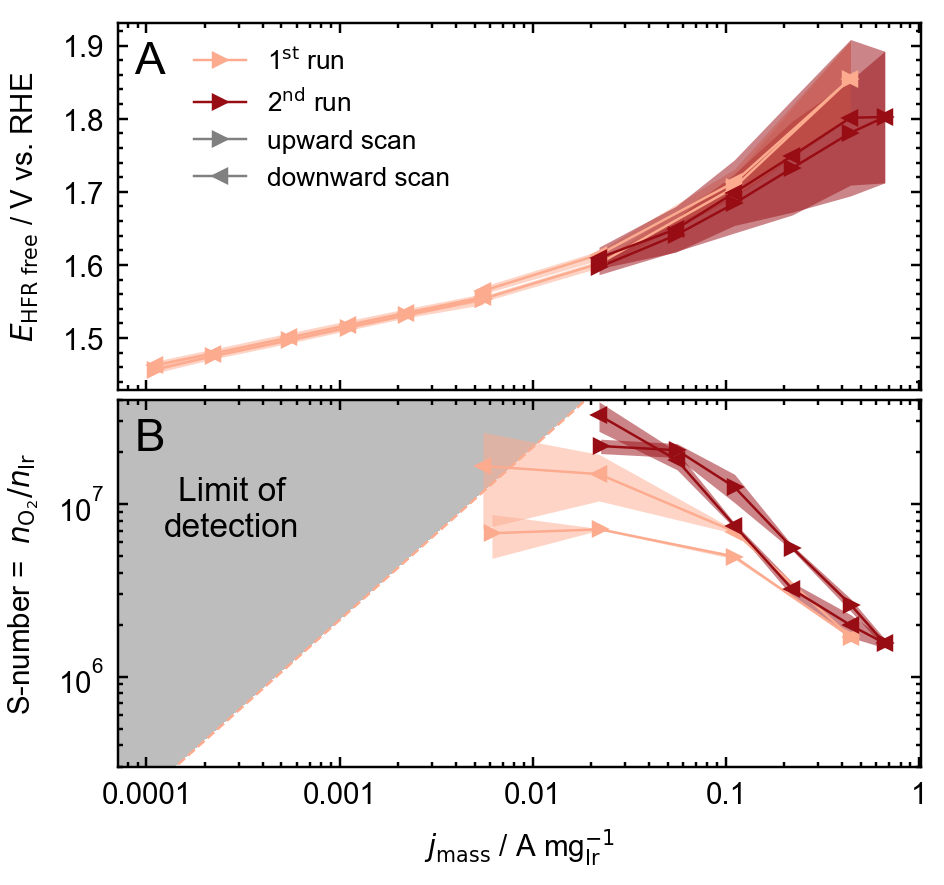

In [42]:
exp_ec_polcurve_avg.loc[:, 'protocol'] = 'polcurve1'
exp_ec_polcurve_avg_polcurve2.loc[:, 'protocol'] = 'polcurve2'
exp_ec_polcurve_avg_polcurve2_plot = pd.concat([exp_ec_polcurve_avg.loc[([179, ], slice(None))], 
                                                exp_ec_polcurve_avg_polcurve2
                                               ])

if 'ax_plot_objects' in exp_ec_polcurve_avg_polcurve2_plot.columns:
    exp_ec_polcurve_avg_polcurve2_plot.drop(columns=['ax_plot_objects'], inplace=True)
data_ec_polcurve_avg_polcurve2_plot = pd.concat([data_ec_polcurve_avg.loc[([179, ], slice(None))], 
                                                 data_ec_polcurve_avg_polcurve2
                                               ])
data_stability_Ir_avg.loc[:, 'protocol'] = 'polcurve1'
data_stability_Ir_avg_polcurve2.loc[:, 'protocol'] = 'polcurve2'
new_index=['id_sample', 'name_isotope_analyte', 'name_isotope_internalstandard', 'protocol', 'scan_direction', 'I_step__A']
data_stability_Ir_avg_polcurve2_plot = pd.concat([data_stability_Ir_avg.loc[([179, ], )].reset_index().set_index(new_index),
                                                  data_stability_Ir_avg_polcurve2.reset_index().set_index(new_index),
                                                 ])
exp_stability_Ir_avg.loc[:, 'protocol'] = 'polcurve1'
exp_stability_Ir_avg_polcurve2.loc[:, 'protocol'] = 'polcurve2'
exp_stability_Ir_avg_polcurve2_plot = pd.concat([exp_stability_Ir_avg.loc[([179, ], )].reset_index().set_index(new_index[:-2]),
                                                  exp_stability_Ir_avg_polcurve2.reset_index().set_index(new_index[:-2]),
                                                 ])
if 'ax_plot_objects' in exp_stability_Ir_avg_polcurve2_plot.columns:
    exp_stability_Ir_avg_polcurve2_plot.drop(columns=['ax_plot_objects'], inplace=True)
exp_stability_Ir_avg_polcurve2_plot


plot.manual_col_to_axis_label['j__A_mg_Ir_geo_fc_bottom_PTL'] = '$j_\mathrm{mass}$ / A mg$_{\mathrm{Ir}}^{-1}$'
plot.manual_col_to_axis_label['S_number_trapz'] = 'S-number =  $n_{\mathrm{O}_2} / n_{\mathrm{Ir}}$'
plot.manual_col_to_axis_label['S_number_top'] = 'S-number =  $n_{\mathrm{O}_2} / n_{\mathrm{Ir}}$'
plot.manual_col_to_axis_label['E_WE__VvsRHE'] = '$E_{\\mathrm{HFR\\ free}}$ / V vs. RHE'


x_col_EC_ICPMS='j__A_mg_Ir_geo_fc_bottom_PTL'
y_col_EC = 'E_WE__VvsRHE'
y_col_ICPMS='S_number_top'


with plt.rc_context(plot.get_style(style='singleColumn',
                                   increase_fig_height=1.5,
                                   interactive=True,
                                   add_margins={'bottom':0.2, },
                                  )):
    plot_storage = plot.PlotDataStorage('sfig_polcurve_stability_gravimetric_polcurve2', overwrite_existing=True)
    fig = plt.figure()
    gs = gridspec.GridSpec(2, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    plt.setp(ax1.get_xticklabels(), visible=False)
    axs = [ax1, ax2]



    plot_forward_backward_avg(exp_ec_polcurve_avg_polcurve2_plot.dataset\
                                                .add_column('label',
                                                       values=['1$^\mathrm{st}$ run', '2$^\mathrm{nd}$ run'],
                                                     #rowindexers=[exp_stability_Ir_avg_polcurve2_plot.index.get_level_values('protocol')=='polcurve1',
                                                     #             exp_stability_Ir_avg_polcurve2_plot.index.get_level_values('protocol')=='polcurve2',],
                                                     rowindexer_first_of_group='protocol',
                                                           )\
                                                  .add_column('color',
                                                       values=['Reds',],#'Spot: '+exp_stability_Ir.id_spot.astype(str)
                                                     cmap_group='protocol',
                                                     cmap_min=0.3,cmap_max=0.9,)\
                                                  .return_dataset(), 
                                  x_col=x_col_EC_ICPMS,
                                  y_col=y_col_EC,
                                  ymin_col=y_col_EC+'_min',
                                  ymax_col=y_col_EC+'_max',
                                  data=data_ec_polcurve_avg_polcurve2_plot, 
                                  marker_for='>', 
                                  marker_back='<', 
                                  back_for_col='scan_direction',
                                  back_for_crit=1.5, 
                                  ax=ax1,
                                  axlabel_auto=True,
                                  )

    plot_forward_backward_avg(exp_stability_Ir_avg_polcurve2_plot.dataset\
                                                .add_column('color',
                                                       values=['Reds',],
                                                     cmap_group='protocol',
                                                     cmap_min=0.3,cmap_max=0.9,)\
                                          .return_dataset(), 
                  x_col=x_col_EC_ICPMS,
                  y_col=y_col_ICPMS,
                  ymin_col=y_col_ICPMS+'_min',
                  ymax_col=y_col_ICPMS+'_max',
                  data=data_stability_Ir_avg_polcurve2_plot.reset_index('scan_direction'), 
                  marker_for='>', 
                  marker_back='<', 
                  back_for_col='scan_direction',
                  back_for_crit=1.5, 
                  ax=ax2,
                          axlabel_auto=True,
                  )

    
    handles, labels = ax1.get_legend_handles_labels()
    handles += [plot.legend_handle_line(marker='>', color='grey'),
                plot.legend_handle_line(marker='<', color='grey'),
               ]
    labels += ['upward scan',
               'downward scan'
              ]


    plot_labels = list(string.ascii_uppercase)[:len(axs)]

    for ax, plot_label in zip(axs, plot_labels):
        ax.text(0.02, 0.95, plot_label, 
                    horizontalalignment='left', 
                    verticalalignment='top', 
                    transform=ax.transAxes,
                    fontsize=11)

    
    
    
    
    ax1.set_xscale('log')
    ax2.set_yscale('log')
    ax2.xaxis.set_major_formatter(lambda x, pos: ("%.8f" %x).rstrip('.0'))
    
    ax1.set_xlabel('')


    ax1.legend(handles, labels , loc='upper left', bbox_to_anchor=(0.065, 1.0))
    ax2.set_ylim([0.3e6, 4e7])#[1.4,1.7])
    ##


    #######
    # grey box for detection limit, three areas
    #######
    
    # 1. gray:      below 3sigma detection limit for all loadings
    # 2. white:     above the 3sigma detection for all loadings
    # dissolution rate can be referred to S-number
    # detection limit is 3*standard deviation of noise in dissolution signal --> dm_dt_S_std__g_s_cm2 (from dissolution profile)
    
    ax2_xlims = ax2.get_xlim()
    ax2_ylims = ax2.get_ylim()
    M_Ir__g_mol = 192.22
    z = 4
    F__C_mol = scipy.constants.physical_constants['Faraday constant'][0]
    dm_dt_S_std__g_s_cm2 = dm_dt_S_std_allexp__g_s_cm2.loc[lambda row: ((row.index.get_level_values('id_sample')==179) 
                                             & (row.index.get_level_values('icpms_location')=='top'))].max() # ~0.0001 ng/(s cm2) # choose the maximum standard deviation of all experiments
    m_Ir_loading_max__mg_cm2 = exp_icpms_overlay.loading__mg_Ir_cm2.max()#min() # detection limit in terms of gravimetric higher for lower loadings, but difficult to display in one plot
    factor_std_signal = 3


    # Create a meshgrid over the whole plot
    x = np.logspace(np.log10(ax2_xlims[0])-1, np.log10(ax2_xlims[1])+1, 500)
    y = np.logspace(np.log10(ax2_ylims[0])-1, np.log10(ax2_ylims[1])+1, 500)
    X, Y = np.meshgrid(x, y)
    
    # Define slope of borders
    def limit_slope_grav(m_Ir_loading__mg_cm2, 
                    M_Ir__g_mol, 
                    z, 
                    F__C_mol,
                    dm_dt_S_std__g_s_cm2,
                   ):
        # should return unit: mg / A
        # from S_number definition: S = nO2 / nIr = M(Ir) * loading(Ir) / (z * F * dm_dt_S) * j_mass
        return m_Ir_loading__mg_cm2 * M_Ir__g_mol / (z * F__C_mol * dm_dt_S_std__g_s_cm2)
    
    limit_slope_max = limit_slope_grav(m_Ir_loading_max__mg_cm2, M_Ir__g_mol, z, F__C_mol,dm_dt_S_std__g_s_cm2,)
    limit = Y / (limit_slope_max * X ) 

    # Define border white--grayscale as mask for the box
    mask = limit >= (1 / factor_std_signal)

    # Define border grayscale--gray
    cmap_val = limit
    cmap_val[limit >= (1 / factor_std_signal)+0.0001] = (1 / factor_std_signal) # constant color for dissolution rates below standard deviation, color gradient only for condition 2

    
    
    # Apply the mask to ensure we only plot points fulfilling condition 1 or 2
    # adjust grayscale more smoothly
    cmap_gradient = np.ma.masked_where(~mask, cmap_val)

    
    
    
    text_y_percent = 0.7
    text_x_percent = 0.45
    text_y_axes = 10**(np.log10(ax2_ylims[0]) + (np.log10(ax2_ylims[1])-np.log10(ax2_ylims[0]))*text_y_percent)
    text_x_axes = 10**(np.log10(ax2_xlims[0]) + (np.log10(text_y_axes/limit_slope_max)-np.log10(ax2_xlims[0]))*text_x_percent)

    
    ax2.text(text_x_axes, # transform data coordinates to Axes coordinates for x-coordinate between xlim_min and detection limit
             text_y_axes,
             "Limit of\ndetection", 
             fontsize=8,
             ha='center',
             va='center',
             ma='center',
            )

    for index, row in exp_ec_polcurve_avg_polcurve2_plot.groupby('id_sample')[['color', 'loading__mg_Ir_cm2']].first().iterrows():
        line, = ax2.plot(x,  
                         (limit_slope_grav(row.loading__mg_Ir_cm2, M_Ir__g_mol, z, F__C_mol,dm_dt_S_std__g_s_cm2,)/factor_std_signal * x), 
                         color=row.color,
                        linestyle='--',
                        zorder=0.1)

    ax2.contourf(X, 
                 Y, 
                 cmap_gradient, 
                 100, cmap='Greys',
                 vmax=cmap_gradient.max()+(cmap_gradient.max() - cmap_gradient.min())*1.5,
                 vmin=cmap_gradient.min()-(cmap_gradient.max() - cmap_gradient.min())*1.5,
                zorder=0)
    
    
    
    ax2.set_ylim(ax2_ylims)
    ax2.set_xlim(ax2_xlims)


    fig.align_ylabels(axs)
    plot_storage.export(fig, plot_format='pdf')
    plt.show()